In [21]:
import h5py
import numpy as np
import os,random
from tensorflow.keras.layers import Input,Add,Reshape,AveragePooling2D,ZeroPadding2D,BatchNormalization,MaxPool2D,Conv1D,Conv2D,Dropout,Flatten,Dense,Activation,MaxPooling2D,AlphaDropout
from tensorflow.keras import layers
import tensorflow.keras.models as Model
from tensorflow.keras.regularizers import *
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import GlorotUniform as glorot_uniform
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
import tensorflow_addons as tfa

In [22]:
f = h5py.File('ExtractDataset/part0.h5')
sample_num = f['X'].shape[0]
# idx = np.random.choice(range(0,sample_num),size=3375)
idx = np.random.choice(range(0,sample_num),size=60000)
X = f['X'][:][idx]
Y = f['Y'][:][idx]
Z = f['Z'][:][idx]
f.close()

for i in range(1,24):
    if i%1 == 0:
        !free -m
    '''if i == 10:
        continue'''
    filename = 'ExtractDataset/part'+str(i) + '.h5'
    print(filename)
    f = h5py.File(filename,'r')
    X = np.vstack((X,f['X'][:][idx]))
    Y = np.vstack((Y,f['Y'][:][idx]))
    Z = np.vstack((Z,f['Z'][:][idx]))
    f.close()


print('X-size：',X.shape)
print('Y-size：',Y.shape)
print('Z-size：',Z.shape)

               total        used        free      shared  buff/cache   available
Mem:          128494       43540       62444         231       22509       83499
Swap:           2047           0        2047
ExtractDataset/part1.h5
               total        used        free      shared  buff/cache   available
Mem:          128494       44038       61945         231       22510       83001
Swap:           2047           0        2047
ExtractDataset/part2.h5
               total        used        free      shared  buff/cache   available
Mem:          128494       44478       61505         231       22510       82561
Swap:           2047           0        2047
ExtractDataset/part3.h5
               total        used        free      shared  buff/cache   available
Mem:          128494       44953       61030         231       22510       82085
Swap:           2047           0        2047
ExtractDataset/part4.h5
               total        used        free      shared  buff/cache   avail

## Data preprocessing, and obtain training set and test set

In [23]:
n_examples = X.shape[0]
# n_train = int(n_examples * 0.9877) 
n_train = int(n_examples * 0.8)  
train_idx = np.random.choice(range(0,n_examples), size=n_train, replace=False)  #Randomly select training sample subscript
test_idx = list(set(range(0,n_examples))-set(train_idx)) #Test sample index
X_train = X[train_idx]  #training samples
X_test =  X[test_idx]  #testing samples
Y_train = Y[train_idx]
Y_test = Y[test_idx]
print("X_train:",X_train.shape)
print("Y_train:",Y_train.shape)
print("X_test:",X_test.shape)
print("Y_test:",Y_test.shape)

X_train: (1152000, 1024, 2)
Y_train: (1152000, 24)
X_test: (288000, 1024, 2)
Y_test: (288000, 24)


In [24]:
X_train[0]

array([[-0.44410443, -0.00123893],
       [ 0.6382383 ,  0.8401811 ],
       [-0.66759646,  0.09726848],
       ...,
       [-0.6001677 , -1.1476858 ],
       [ 0.30774203,  0.29794043],
       [-1.1626605 ,  0.3459837 ]], dtype=float32)

In [25]:
X_train.shape[1:] 
# Input(in_shp)

(1024, 2)

In [26]:
classes = ['32PSK',
 '16APSK',
 '32QAM',
 'FM',
 'GMSK',
 '32APSK',
 'OQPSK',
 '8ASK',
 'BPSK',
 '8PSK',
 'AM-SSB-SC',
 '4ASK',
 '16PSK',
 '64APSK',
 '128QAM',
 '128APSK',
 'AM-DSB-SC',
 'AM-SSB-WC',
 '64QAM',
 'QPSK',
 '256QAM',
 'AM-DSB-WC',
 'OOK',
 '16QAM']

   
def residual_stack(X,Filters,Seq,max_pool):
    #1*1 Conv Linear
    X = Conv2D(Filters, (1, 1), padding='same', name=Seq+"_conv1", kernel_initializer='glorot_uniform',data_format="channels_first")(X)
    X = BatchNormalization(axis = 3)(X)

    #Residual Unit 1
    X_shortcut = X
    X = Conv2D(Filters, (3, 2), padding='same',activation="relu",name=Seq+"_conv2", kernel_initializer='glorot_uniform',data_format="channels_first")(X)
    X = Conv2D(Filters, (3, 2), padding='same', name=Seq+"_conv3", kernel_initializer='glorot_uniform',data_format="channels_first")(X)
    X = BatchNormalization(axis = 3)(X)

    X = layers.add([X,X_shortcut])
    X = Activation("relu")(X)
    #Residual Unit 2
    X_shortcut = X
    X = Conv2D(Filters, (3, 2), padding='same',activation="relu",name=Seq+"_conv4", kernel_initializer='glorot_uniform',data_format="channels_first")(X)
    X = Conv2D(Filters, (3, 2), padding='same', name=Seq+"_conv5", kernel_initializer='glorot_uniform',data_format="channels_first")(X)
    X = BatchNormalization(axis = 3)(X)

    
    X = layers.add([X,X_shortcut])
    X = Activation("relu")(X)
    #MaxPooling
    if max_pool:
        X = MaxPooling2D(pool_size=(2, 1), strides=(2, 1), padding='valid', data_format="channels_first")(X)
    return X

mirrored_strategy = tf.distribute.MirroredStrategy(devices=["/gpu:0","/gpu:1","/gpu:2"], cross_device_ops=tf.distribute.HierarchicalCopyAllReduce())

with mirrored_strategy.scope():
    in_shp = X_train.shape[1:]   #Dimensions of each sample
    #input layer
    X_input = Input(in_shp)
    X = Reshape([1,1024,2], input_shape=in_shp)(X_input)
    #Residual Srack 1
    X = residual_stack(X,32,"ReStk1",False)  #shape:(1,512,32)
    X = MaxPooling2D(pool_size=(2, 2), strides=(2, 1), padding='valid', data_format="channels_first")(X)
    #Residual Srack 2
    X = residual_stack(X,32,"ReStk2",True)  #shape:(1,256,32)
    #Residual Srack 3
    X = residual_stack(X,64,"ReStk3",True)  #shape:(1,128,32)
    #Residual Srack 4
    X = residual_stack(X,64,"ReStk4",True)  #shape:(1,64,32)
    #Residual Srack 5
    # X = residual_stack(X,32,"ReStk5",True)  #shape:(1,32,32)
    # #Residual Srack 6
    # X = residual_stack(X,32,"ReStk6",True)  #shape:(1,16,32)
    #Full Con 1
    X = Flatten()(X)
    X = Dense(128, activation='selu', kernel_initializer='he_normal', name="dense1")(X)
    X = Dropout(0.3)(X)
    #Full Con 2
    X = Dense(128, activation='selu', kernel_initializer='he_normal', name="dense2")(X)
    X = Dropout(0.3)(X)
    #Full Con 3
    X = Dense(len(classes), kernel_initializer='he_normal', name="dense3")(X)
    #SoftMax
    X = Activation('softmax')(X)
    #Create Model
    model = Model.Model(inputs=X_input,outputs=X)
model.load_weights('resnet2_model.h5')
model.compile(loss='categorical_crossentropy', optimizer=tfa.optimizers.LazyAdam(),metrics=['accuracy'])
model.summary()

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2')
Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 1024, 2)]    0           []                               
                                                                                                  
 reshape_2 (Reshape)            (None, 1, 1024, 2)   0           ['input_3[0][0]']                
                                                                                                  
 ReStk1_conv1 (Conv2D)          (None, 32, 1024, 2)  64          ['reshape_2[0][0]']              
                                                                                             

In [27]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [28]:
%%time
filepath = 'resnet_model_mix.h5'
history = model.fit(X_train,
    Y_train,
    batch_size=1024,
    epochs=100,
    verbose=2,
    # validation_data=(X_test, Y_test),
    validation_split = 0.2,
    callbacks = [
        tf.keras.callbacks.ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='auto'),
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='auto')
    ])

Epoch 1/100


2024-06-15 21:04:40.120851: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype int64 and shape [921600,24]
	 [[{{node Placeholder/_11}}]]
2024-06-15 21:04:40.121015: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype int64 and shape [921600,24]
	 [[{{node Placeholder/_11}}]]
2024-06-15 21:04:40.188251: W tensorflow/core/framework/dataset.cc:807] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.
2024-06-15 21:04:40.188421: I tensorflow/core/common_runtime/execut


Epoch 1: val_loss improved from inf to 1.27166, saving model to resnet_model_mix.h5
900/900 - 261s - loss: 1.2653 - accuracy: 0.5852 - val_loss: 1.2717 - val_accuracy: 0.5802 - 261s/epoch - 290ms/step
Epoch 2/100


2024-06-15 21:13:08.126188: W tensorflow/core/framework/dataset.cc:807] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.
2024-06-15 21:13:08.126349: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype variant
	 [[{{node Placeholder/_0}}]]
2024-06-15 21:13:08.132703: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype variant
	 [[{{node Placeholder/_0}}]]



Epoch 2: val_loss did not improve from 1.27166
900/900 - 255s - loss: 1.2415 - accuracy: 0.5938 - val_loss: 1.2909 - val_accuracy: 0.5758 - 255s/epoch - 284ms/step
Epoch 3/100


2024-06-15 21:17:22.911730: W tensorflow/core/framework/dataset.cc:807] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.
2024-06-15 21:17:22.911893: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype variant
	 [[{{node Placeholder/_0}}]]
2024-06-15 21:17:22.918115: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype variant
	 [[{{node Placeholder/_0}}]]



Epoch 3: val_loss did not improve from 1.27166
900/900 - 255s - loss: 1.2229 - accuracy: 0.6015 - val_loss: 1.3225 - val_accuracy: 0.5727 - 255s/epoch - 283ms/step
Epoch 4/100


2024-06-15 21:21:37.684726: W tensorflow/core/framework/dataset.cc:807] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.
2024-06-15 21:21:37.684900: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype variant
	 [[{{node Placeholder/_0}}]]
2024-06-15 21:21:37.691658: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype variant
	 [[{{node Placeholder/_0}}]]



Epoch 4: val_loss improved from 1.27166 to 1.22000, saving model to resnet_model_mix.h5
900/900 - 255s - loss: 1.2102 - accuracy: 0.6071 - val_loss: 1.2200 - val_accuracy: 0.6024 - 255s/epoch - 283ms/step
Epoch 5/100


2024-06-15 21:25:52.561541: W tensorflow/core/framework/dataset.cc:807] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.
2024-06-15 21:25:52.561724: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype variant
	 [[{{node Placeholder/_0}}]]
2024-06-15 21:25:52.569241: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype variant
	 [[{{node Placeholder/_0}}]]



Epoch 5: val_loss did not improve from 1.22000
900/900 - 255s - loss: 1.1997 - accuracy: 0.6116 - val_loss: 1.2368 - val_accuracy: 0.5953 - 255s/epoch - 283ms/step
Epoch 6/100


2024-06-15 21:30:07.263059: W tensorflow/core/framework/dataset.cc:807] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.
2024-06-15 21:30:07.263281: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype variant
	 [[{{node Placeholder/_0}}]]
2024-06-15 21:30:07.270533: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype variant
	 [[{{node Placeholder/_0}}]]



Epoch 6: val_loss improved from 1.22000 to 1.20678, saving model to resnet_model_mix.h5
900/900 - 255s - loss: 1.1910 - accuracy: 0.6154 - val_loss: 1.2068 - val_accuracy: 0.6088 - 255s/epoch - 283ms/step
Epoch 7/100


2024-06-15 21:34:22.098431: W tensorflow/core/framework/dataset.cc:807] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.
2024-06-15 21:34:22.098595: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype variant
	 [[{{node Placeholder/_0}}]]
2024-06-15 21:34:22.104868: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype variant
	 [[{{node Placeholder/_0}}]]



Epoch 7: val_loss did not improve from 1.20678
900/900 - 255s - loss: 1.1818 - accuracy: 0.6191 - val_loss: 1.2383 - val_accuracy: 0.5999 - 255s/epoch - 283ms/step
Epoch 8/100


2024-06-15 21:38:36.897001: W tensorflow/core/framework/dataset.cc:807] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.
2024-06-15 21:38:36.897186: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype variant
	 [[{{node Placeholder/_0}}]]
2024-06-15 21:38:36.903438: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype variant
	 [[{{node Placeholder/_0}}]]



Epoch 8: val_loss did not improve from 1.20678
900/900 - 255s - loss: 1.1809 - accuracy: 0.6199 - val_loss: 1.2483 - val_accuracy: 0.5971 - 255s/epoch - 283ms/step
Epoch 9/100


2024-06-15 21:42:51.647312: W tensorflow/core/framework/dataset.cc:807] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.
2024-06-15 21:42:51.647533: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype variant
	 [[{{node Placeholder/_0}}]]
2024-06-15 21:42:51.653999: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype variant
	 [[{{node Placeholder/_0}}]]



Epoch 9: val_loss did not improve from 1.20678
900/900 - 255s - loss: 1.1641 - accuracy: 0.6269 - val_loss: 1.2701 - val_accuracy: 0.5929 - 255s/epoch - 283ms/step
Epoch 10/100


2024-06-15 21:47:06.313359: W tensorflow/core/framework/dataset.cc:807] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.
2024-06-15 21:47:06.313592: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype variant
	 [[{{node Placeholder/_0}}]]
2024-06-15 21:47:06.320793: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype variant
	 [[{{node Placeholder/_0}}]]



Epoch 10: val_loss did not improve from 1.20678
900/900 - 255s - loss: 1.1576 - accuracy: 0.6296 - val_loss: 1.3606 - val_accuracy: 0.5692 - 255s/epoch - 283ms/step
Epoch 11/100


2024-06-15 21:51:20.866623: W tensorflow/core/framework/dataset.cc:807] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.
2024-06-15 21:51:20.866783: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype variant
	 [[{{node Placeholder/_0}}]]
2024-06-15 21:51:20.873003: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype variant
	 [[{{node Placeholder/_0}}]]



Epoch 11: val_loss did not improve from 1.20678
900/900 - 255s - loss: 1.1507 - accuracy: 0.6323 - val_loss: 1.2152 - val_accuracy: 0.6099 - 255s/epoch - 283ms/step
Epoch 12/100


2024-06-15 21:55:35.507018: W tensorflow/core/framework/dataset.cc:807] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.
2024-06-15 21:55:35.507315: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype variant
	 [[{{node Placeholder/_0}}]]
2024-06-15 21:55:35.516115: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype variant
	 [[{{node Placeholder/_0}}]]



Epoch 12: val_loss improved from 1.20678 to 1.19678, saving model to resnet_model_mix.h5
900/900 - 255s - loss: 1.1466 - accuracy: 0.6341 - val_loss: 1.1968 - val_accuracy: 0.6165 - 255s/epoch - 283ms/step
Epoch 13/100


2024-06-15 21:59:50.344982: W tensorflow/core/framework/dataset.cc:807] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.
2024-06-15 21:59:50.345154: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype variant
	 [[{{node Placeholder/_0}}]]
2024-06-15 21:59:50.351184: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype variant
	 [[{{node Placeholder/_0}}]]



Epoch 13: val_loss did not improve from 1.19678
900/900 - 255s - loss: 1.1396 - accuracy: 0.6367 - val_loss: 1.2765 - val_accuracy: 0.5952 - 255s/epoch - 283ms/step
Epoch 14/100


2024-06-15 22:04:04.867020: W tensorflow/core/framework/dataset.cc:807] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.
2024-06-15 22:04:04.867217: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype variant
	 [[{{node Placeholder/_0}}]]
2024-06-15 22:04:04.873587: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype variant
	 [[{{node Placeholder/_0}}]]



Epoch 14: val_loss did not improve from 1.19678
900/900 - 255s - loss: 1.1331 - accuracy: 0.6394 - val_loss: 1.3129 - val_accuracy: 0.5931 - 255s/epoch - 283ms/step
Epoch 15/100


2024-06-15 22:08:19.558229: W tensorflow/core/framework/dataset.cc:807] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.
2024-06-15 22:08:19.558387: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype variant
	 [[{{node Placeholder/_0}}]]
2024-06-15 22:08:19.564463: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype variant
	 [[{{node Placeholder/_0}}]]



Epoch 15: val_loss improved from 1.19678 to 1.18546, saving model to resnet_model_mix.h5
900/900 - 255s - loss: 1.1274 - accuracy: 0.6420 - val_loss: 1.1855 - val_accuracy: 0.6236 - 255s/epoch - 283ms/step
Epoch 16/100


2024-06-15 22:12:34.340111: W tensorflow/core/framework/dataset.cc:807] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.
2024-06-15 22:12:34.340266: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype variant
	 [[{{node Placeholder/_0}}]]
2024-06-15 22:12:34.346661: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype variant
	 [[{{node Placeholder/_0}}]]



Epoch 16: val_loss did not improve from 1.18546
900/900 - 255s - loss: 1.1223 - accuracy: 0.6439 - val_loss: 1.2709 - val_accuracy: 0.6004 - 255s/epoch - 283ms/step
Epoch 17/100


2024-06-15 22:16:49.159715: W tensorflow/core/framework/dataset.cc:807] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.
2024-06-15 22:16:49.159874: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype variant
	 [[{{node Placeholder/_0}}]]
2024-06-15 22:16:49.166962: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype variant
	 [[{{node Placeholder/_0}}]]



Epoch 17: val_loss did not improve from 1.18546
900/900 - 255s - loss: 1.1191 - accuracy: 0.6449 - val_loss: 1.2897 - val_accuracy: 0.5963 - 255s/epoch - 283ms/step
Epoch 18/100


2024-06-15 22:21:03.749392: W tensorflow/core/framework/dataset.cc:807] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.
2024-06-15 22:21:03.749554: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype variant
	 [[{{node Placeholder/_0}}]]
2024-06-15 22:21:03.755697: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype variant
	 [[{{node Placeholder/_0}}]]



Epoch 18: val_loss did not improve from 1.18546
900/900 - 255s - loss: 1.1120 - accuracy: 0.6481 - val_loss: 1.3315 - val_accuracy: 0.5873 - 255s/epoch - 283ms/step
Epoch 19/100


2024-06-15 22:25:18.361293: W tensorflow/core/framework/dataset.cc:807] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.
2024-06-15 22:25:18.361467: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype variant
	 [[{{node Placeholder/_0}}]]
2024-06-15 22:25:18.367864: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype variant
	 [[{{node Placeholder/_0}}]]



Epoch 19: val_loss did not improve from 1.18546
900/900 - 255s - loss: 1.1082 - accuracy: 0.6494 - val_loss: 1.2057 - val_accuracy: 0.6189 - 255s/epoch - 283ms/step
Epoch 20/100


2024-06-15 22:29:33.064929: W tensorflow/core/framework/dataset.cc:807] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.
2024-06-15 22:29:33.065117: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype variant
	 [[{{node Placeholder/_0}}]]
2024-06-15 22:29:33.071348: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype variant
	 [[{{node Placeholder/_0}}]]



Epoch 20: val_loss did not improve from 1.18546
900/900 - 255s - loss: 1.1019 - accuracy: 0.6514 - val_loss: 1.2123 - val_accuracy: 0.6197 - 255s/epoch - 283ms/step
Epoch 21/100


2024-06-15 22:33:47.576800: W tensorflow/core/framework/dataset.cc:807] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.
2024-06-15 22:33:47.576995: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype variant
	 [[{{node Placeholder/_0}}]]
2024-06-15 22:33:47.583276: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype variant
	 [[{{node Placeholder/_0}}]]



Epoch 21: val_loss improved from 1.18546 to 1.18326, saving model to resnet_model_mix.h5
900/900 - 255s - loss: 1.0994 - accuracy: 0.6527 - val_loss: 1.1833 - val_accuracy: 0.6304 - 255s/epoch - 283ms/step
Epoch 22/100


2024-06-15 22:38:02.242211: W tensorflow/core/framework/dataset.cc:807] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.
2024-06-15 22:38:02.242385: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype variant
	 [[{{node Placeholder/_0}}]]
2024-06-15 22:38:02.248698: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype variant
	 [[{{node Placeholder/_0}}]]



Epoch 22: val_loss did not improve from 1.18326
900/900 - 255s - loss: 1.0938 - accuracy: 0.6550 - val_loss: 1.2227 - val_accuracy: 0.6188 - 255s/epoch - 283ms/step
Epoch 23/100


2024-06-15 22:42:16.895650: W tensorflow/core/framework/dataset.cc:807] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.
2024-06-15 22:42:16.895809: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype variant
	 [[{{node Placeholder/_0}}]]
2024-06-15 22:42:16.901876: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype variant
	 [[{{node Placeholder/_0}}]]



Epoch 23: val_loss did not improve from 1.18326
900/900 - 255s - loss: 1.0892 - accuracy: 0.6564 - val_loss: 1.2085 - val_accuracy: 0.6219 - 255s/epoch - 283ms/step
Epoch 24/100


2024-06-15 22:46:31.549920: W tensorflow/core/framework/dataset.cc:807] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.
2024-06-15 22:46:31.550100: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype variant
	 [[{{node Placeholder/_0}}]]
2024-06-15 22:46:31.556721: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype variant
	 [[{{node Placeholder/_0}}]]



Epoch 24: val_loss did not improve from 1.18326
900/900 - 255s - loss: 1.0855 - accuracy: 0.6582 - val_loss: 1.2883 - val_accuracy: 0.6028 - 255s/epoch - 283ms/step
Epoch 25/100


2024-06-15 22:50:46.176793: W tensorflow/core/framework/dataset.cc:807] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.
2024-06-15 22:50:46.176948: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype variant
	 [[{{node Placeholder/_0}}]]
2024-06-15 22:50:46.182982: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype variant
	 [[{{node Placeholder/_0}}]]



Epoch 25: val_loss did not improve from 1.18326
900/900 - 255s - loss: 1.0819 - accuracy: 0.6593 - val_loss: 1.2345 - val_accuracy: 0.6192 - 255s/epoch - 283ms/step
Epoch 26/100


2024-06-15 22:55:00.480618: W tensorflow/core/framework/dataset.cc:807] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.
2024-06-15 22:55:00.480807: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype variant
	 [[{{node Placeholder/_0}}]]
2024-06-15 22:55:00.487229: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype variant
	 [[{{node Placeholder/_0}}]]



Epoch 26: val_loss did not improve from 1.18326
900/900 - 254s - loss: 1.0785 - accuracy: 0.6604 - val_loss: 1.1962 - val_accuracy: 0.6257 - 254s/epoch - 283ms/step
Epoch 27/100


2024-06-15 22:59:12.525261: W tensorflow/core/framework/dataset.cc:807] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.
2024-06-15 22:59:12.525437: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype variant
	 [[{{node Placeholder/_0}}]]
2024-06-15 22:59:12.531743: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype variant
	 [[{{node Placeholder/_0}}]]



Epoch 27: val_loss did not improve from 1.18326
900/900 - 252s - loss: 1.0727 - accuracy: 0.6630 - val_loss: 1.2077 - val_accuracy: 0.6244 - 252s/epoch - 280ms/step
Epoch 28/100


2024-06-15 23:03:24.761344: W tensorflow/core/framework/dataset.cc:807] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.
2024-06-15 23:03:24.761497: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype variant
	 [[{{node Placeholder/_0}}]]
2024-06-15 23:03:24.767761: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype variant
	 [[{{node Placeholder/_0}}]]



Epoch 28: val_loss did not improve from 1.18326
900/900 - 252s - loss: 1.0700 - accuracy: 0.6639 - val_loss: 1.2250 - val_accuracy: 0.6218 - 252s/epoch - 280ms/step
Epoch 29/100


2024-06-15 23:07:37.723002: W tensorflow/core/framework/dataset.cc:807] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.
2024-06-15 23:07:37.723176: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype variant
	 [[{{node Placeholder/_0}}]]
2024-06-15 23:07:37.729418: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype variant
	 [[{{node Placeholder/_0}}]]



Epoch 29: val_loss did not improve from 1.18326
900/900 - 253s - loss: 1.0666 - accuracy: 0.6651 - val_loss: 1.2262 - val_accuracy: 0.6218 - 253s/epoch - 281ms/step
Epoch 30/100


2024-06-15 23:11:50.317709: W tensorflow/core/framework/dataset.cc:807] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.
2024-06-15 23:11:50.317900: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype variant
	 [[{{node Placeholder/_0}}]]
2024-06-15 23:11:50.324139: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype variant
	 [[{{node Placeholder/_0}}]]



Epoch 30: val_loss did not improve from 1.18326
900/900 - 253s - loss: 1.0621 - accuracy: 0.6668 - val_loss: 1.2274 - val_accuracy: 0.6184 - 253s/epoch - 281ms/step
Epoch 31/100


2024-06-15 23:16:05.403773: W tensorflow/core/framework/dataset.cc:807] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.
2024-06-15 23:16:05.403936: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype variant
	 [[{{node Placeholder/_0}}]]
2024-06-15 23:16:05.410687: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype variant
	 [[{{node Placeholder/_0}}]]



Epoch 31: val_loss did not improve from 1.18326
900/900 - 256s - loss: 1.0580 - accuracy: 0.6683 - val_loss: 1.2241 - val_accuracy: 0.6257 - 256s/epoch - 284ms/step
Epoch 31: early stopping
CPU times: user 34min 19s, sys: 4min 27s, total: 38min 46s
Wall time: 2h 11min 38s


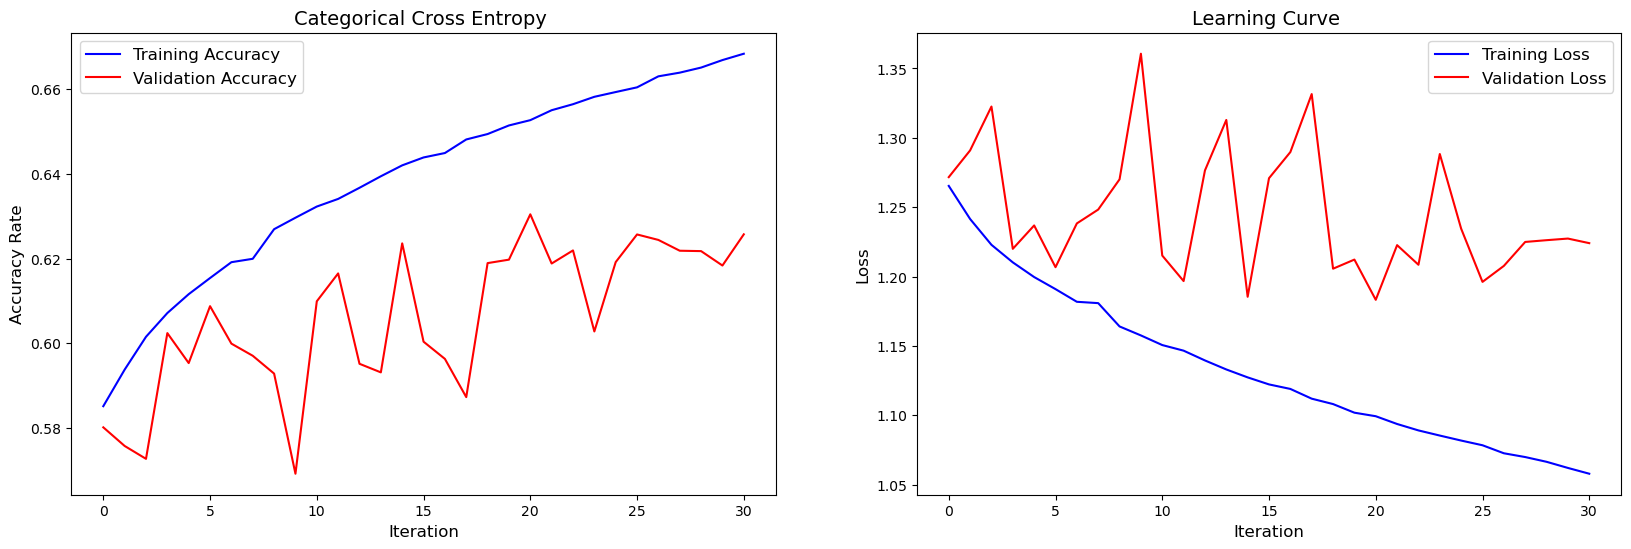

In [29]:
fig, ((ax1, ax2)) = plt.subplots(nrows=1, ncols=2,figsize=(20,6))

ax1.plot(history.history['accuracy'],'b', history.history['val_accuracy'], 'r')
ax1.set_ylabel('Accuracy Rate',fontsize=12)
ax1.set_xlabel('Iteration',fontsize=12)
ax1.set_title('Categorical Cross Entropy ',fontsize=14)
ax1.legend(['Training Accuracy','Validation Accuracy'],fontsize=12,loc='best')

ax2.plot(history.history['loss'], 'b',history.history['val_loss'],'r')
ax2.set_ylabel('Loss',fontsize=12)
ax2.set_xlabel('Iteration',fontsize=12)
ax2.set_title('Learning Curve ',fontsize=14)
ax2.legend(['Training Loss','Validation Loss'],fontsize=12,loc='best')

# plt.savefig('crosse_results.png')
plt.show()

In [30]:
model = load_model(filepath)

96/96 [==============================] - 10s 108ms/step


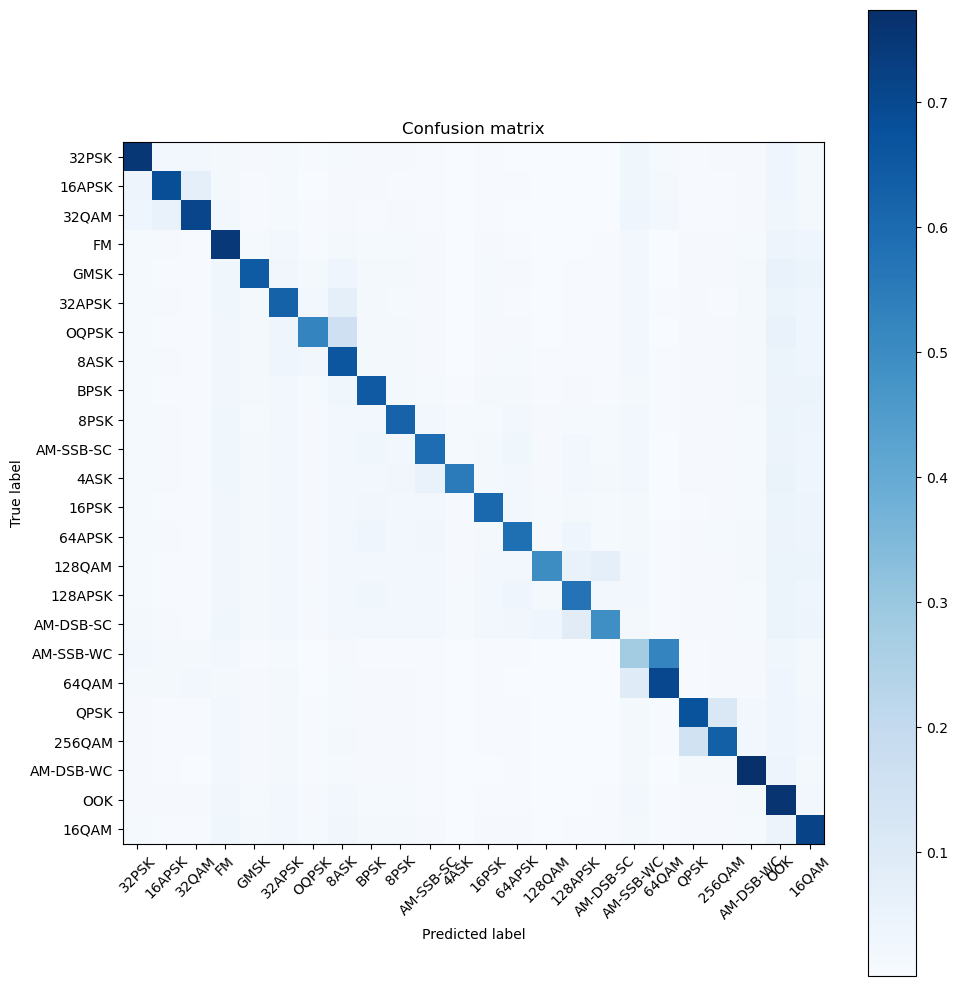

In [31]:
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues, labels=[]):
    plt.figure(figsize=(10, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
# Plot confusion matrix
batch_size = 1024
test_Y_hat = model.predict(X_test, batch_size=3000)
conf = np.zeros([len(classes),len(classes)])
confnorm = np.zeros([len(classes),len(classes)])
for i in range(0,X_test.shape[0]):
    j = list(Y_test[i,:]).index(1)
    k = int(np.argmax(test_Y_hat[i,:]))
    conf[j,k] = conf[j,k] + 1
for i in range(0,len(classes)):
    confnorm[i,:] = conf[i,:] / np.sum(conf[i,:])
plot_confusion_matrix(confnorm, labels=classes)

In [32]:
for i in range(len(confnorm)):
    print(classes[i],confnorm[i,i])

32PSK 0.7527095226276165
16APSK 0.6846243935084491
32QAM 0.7075940971646493
FM 0.7477469889665628
GMSK 0.6443794400334308
32APSK 0.6250415144470276
OQPSK 0.5222708867035782
8ASK 0.6602995624368899
BPSK 0.6487434248977206
8PSK 0.6226921785834173
AM-SSB-SC 0.5926786751888437
4ASK 0.5486696138126617
16PSK 0.6075496798869211
64APSK 0.5839403973509933
128QAM 0.4976326937453277
128APSK 0.5725029575798547
AM-DSB-SC 0.49076451586184044
AM-SSB-WC 0.278489491752491
64QAM 0.7019988388488015
QPSK 0.6705519940054949
256QAM 0.6311217736598279
AM-DSB-WC 0.773953488372093
OOK 0.7577250709871388
16QAM 0.714485596707819


350/350 [==============================] - 1s 2ms/step
Overall Accuracy -20:  0.06462585034013606
353/353 [==============================] - 1s 3ms/step
Overall Accuracy -18:  0.0718653079308817
355/355 [==============================] - 1s 2ms/step
Overall Accuracy -16:  0.06914189963841609
351/351 [==============================] - 1s 3ms/step
Overall Accuracy -14:  0.07631884316700883
352/352 [==============================] - 1s 2ms/step
Overall Accuracy -12:  0.08411131857384191
338/338 [==============================] - 1s 3ms/step
Overall Accuracy -10:  0.10850630096367679
355/355 [==============================] - 1s 2ms/step
Overall Accuracy -8:  0.17236818903191678
352/352 [==============================] - 1s 4ms/step
Overall Accuracy -6:  0.28510487024528974
351/351 [==============================] - 1s 3ms/step
Overall Accuracy -4:  0.4153078499509935
340/340 [==============================] - 1s 2ms/step
Overall Accuracy -2:  0.5390351684772602
350/350 [==================

/tmp/ipykernel_68273/1546757749.py:19: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


347/347 [==============================] - 1s 4ms/step
Overall Accuracy 2:  0.7301730353280461
346/346 [==============================] - 1s 4ms/step
Overall Accuracy 4:  0.8104462750067891
345/345 [==============================] - 1s 4ms/step
Overall Accuracy 6:  0.866569846600708
346/346 [==============================] - 1s 3ms/step
Overall Accuracy 8:  0.9130867323867233
326/326 [==============================] - 1s 2ms/step
Overall Accuracy 10:  0.9437254338030869
358/358 [==============================] - 1s 4ms/step
Overall Accuracy 12:  0.9550148783476282
335/335 [==============================] - 1s 1ms/step
Overall Accuracy 14:  0.9569118609215814
354/354 [==============================] - 0s 1ms/step
Overall Accuracy 16:  0.955305779272502
347/347 [==============================] - 1s 2ms/step
Overall Accuracy 18:  0.9624819624819625
330/330 [==============================] - 1s 2ms/step
Overall Accuracy 20:  0.9592785951589938
345/345 [==============================] - 1s 

<Figure size 640x480 with 0 Axes>

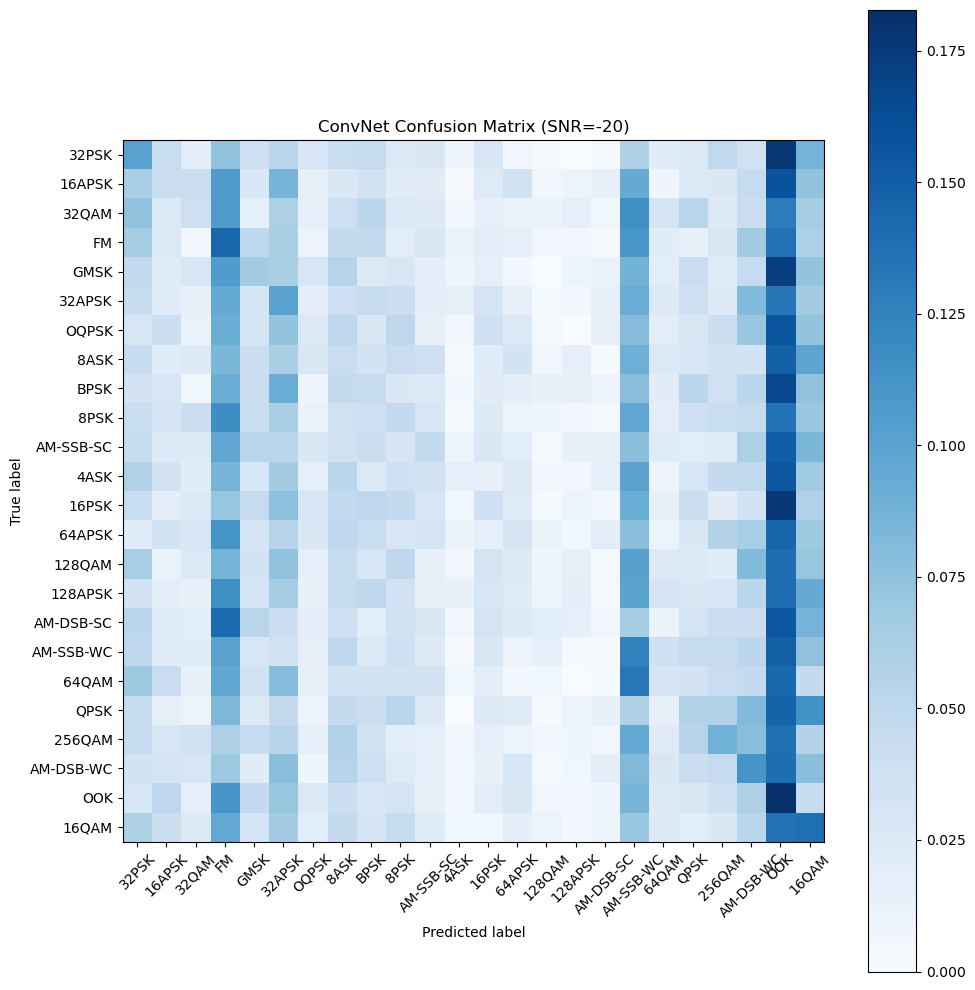

<Figure size 640x480 with 0 Axes>

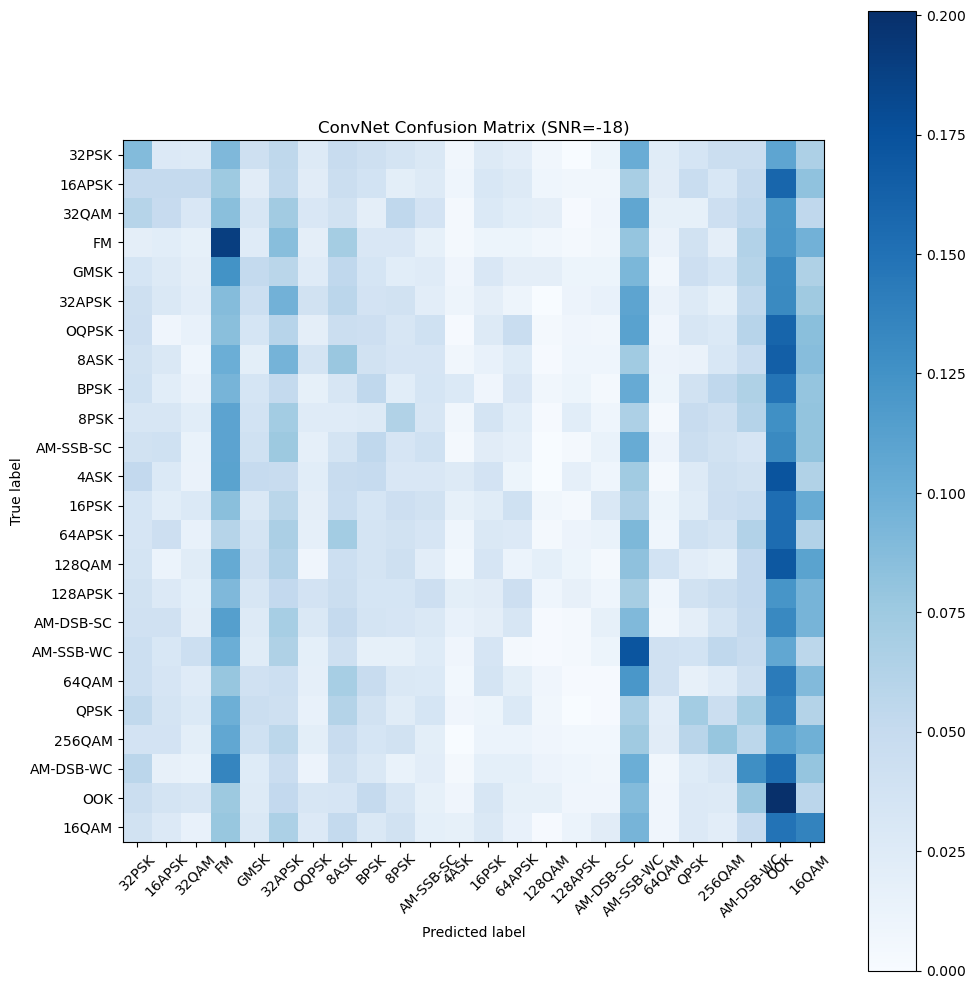

<Figure size 640x480 with 0 Axes>

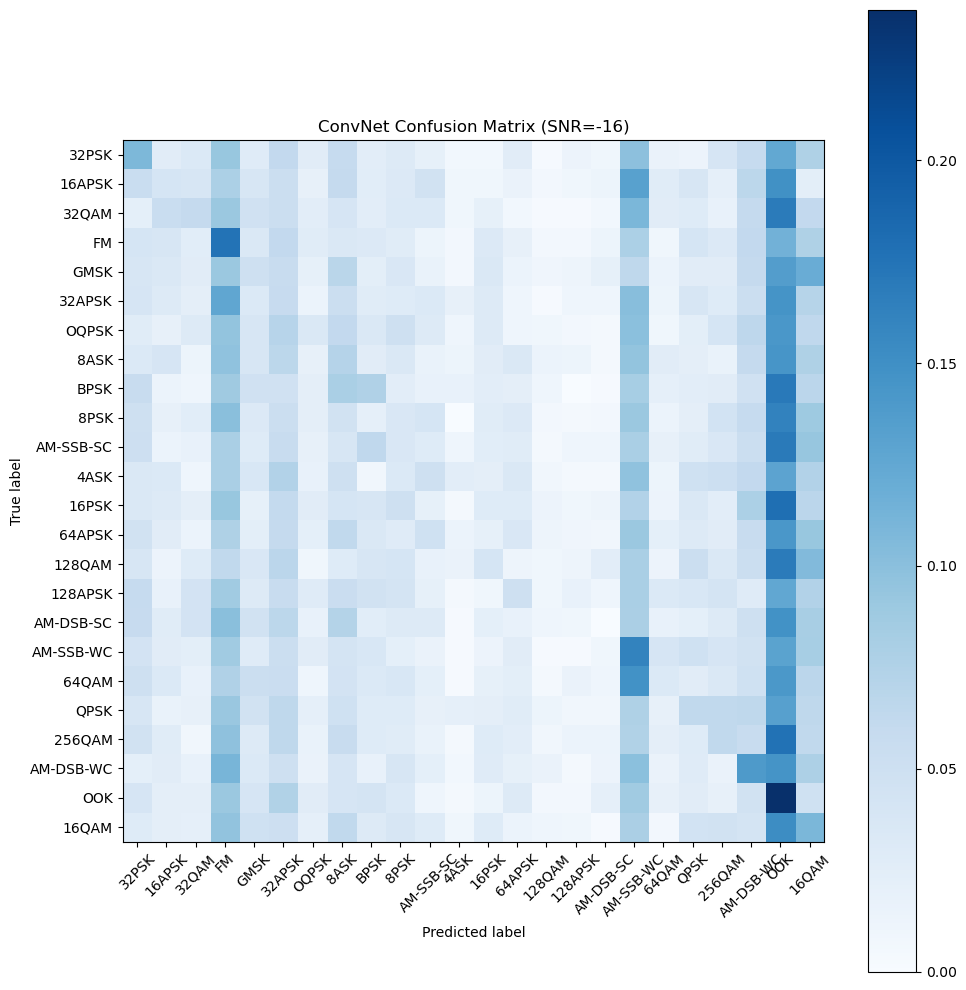

<Figure size 640x480 with 0 Axes>

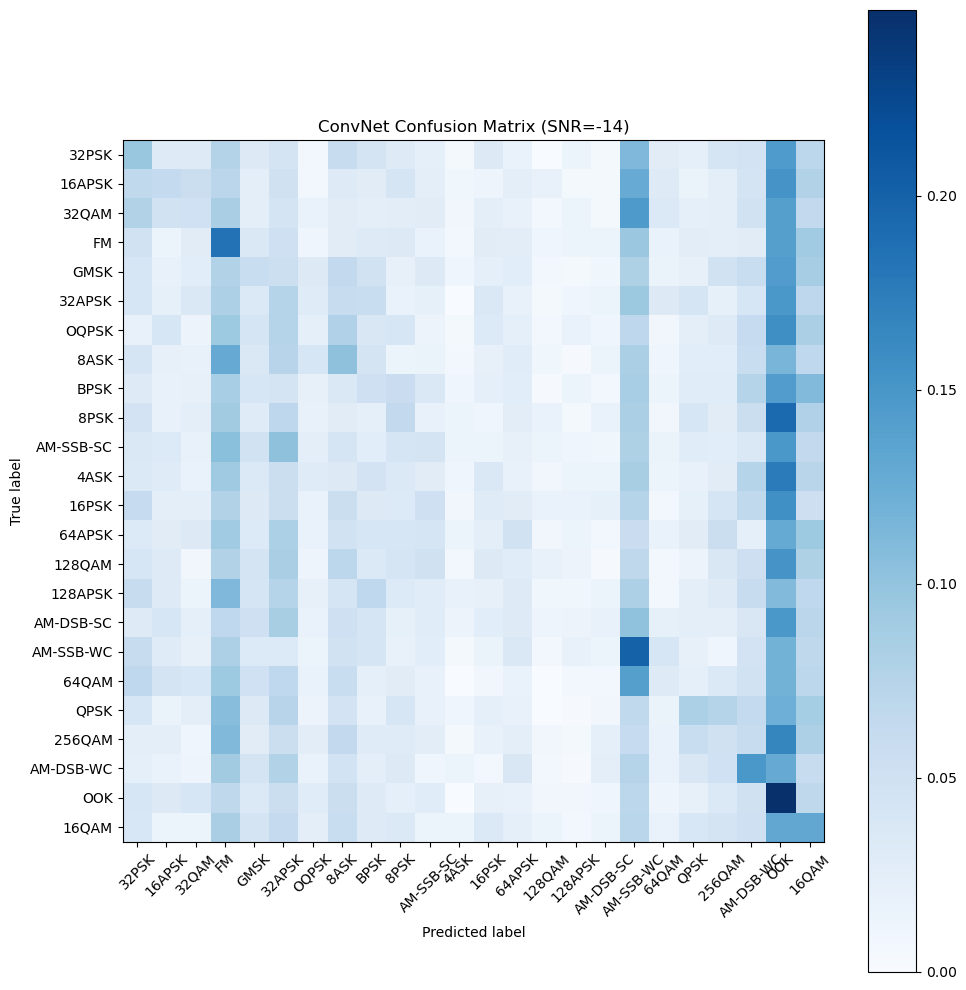

<Figure size 640x480 with 0 Axes>

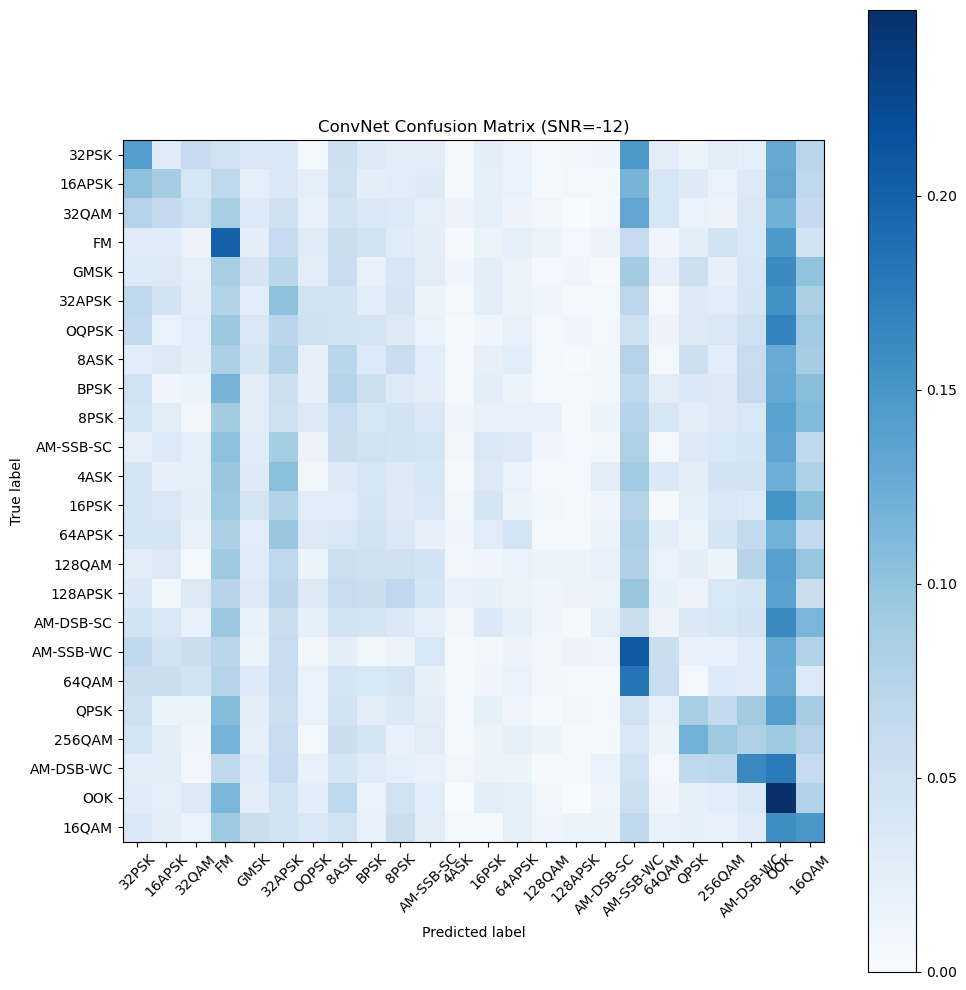

<Figure size 640x480 with 0 Axes>

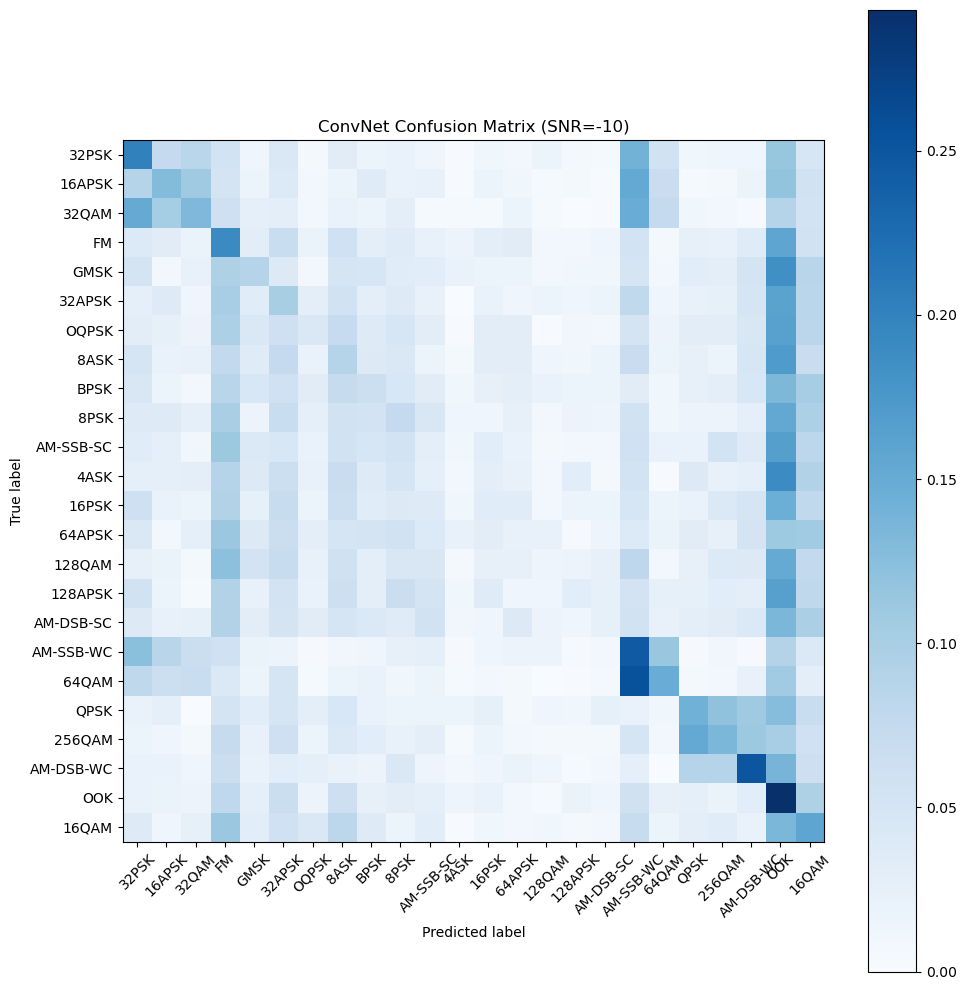

<Figure size 640x480 with 0 Axes>

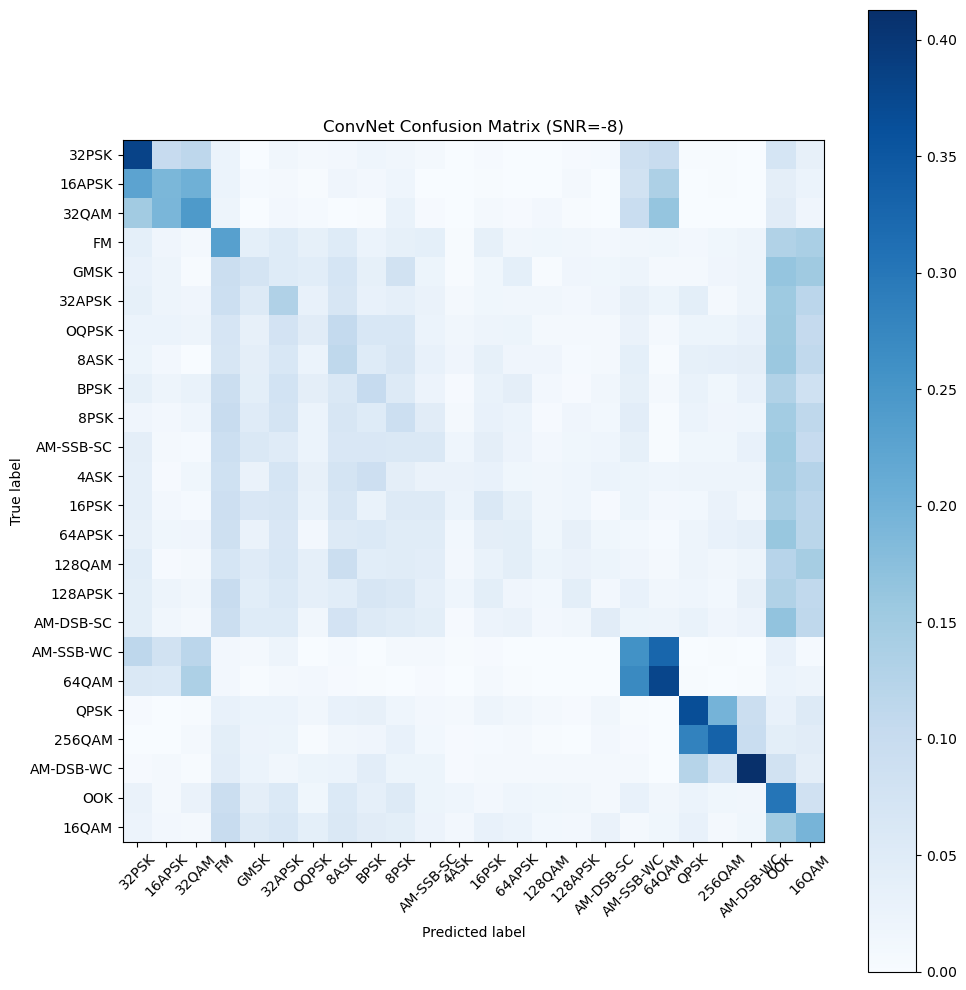

<Figure size 640x480 with 0 Axes>

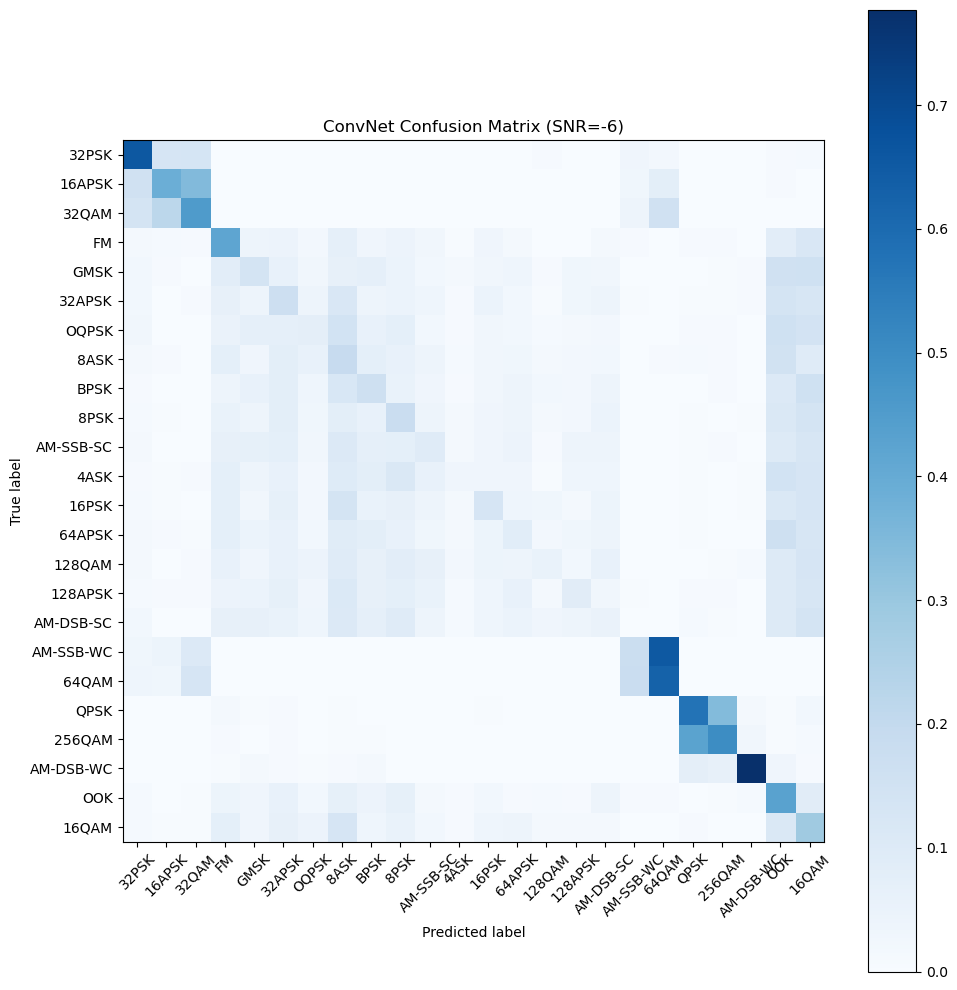

<Figure size 640x480 with 0 Axes>

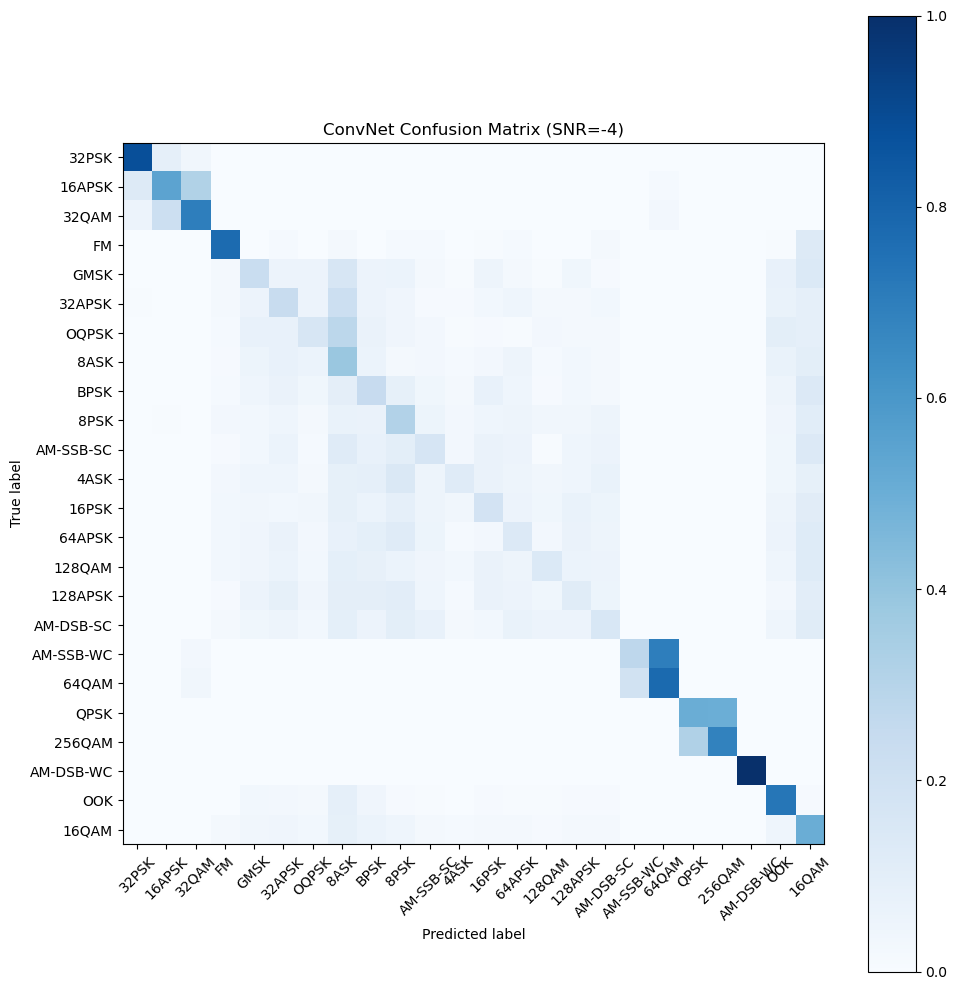

<Figure size 640x480 with 0 Axes>

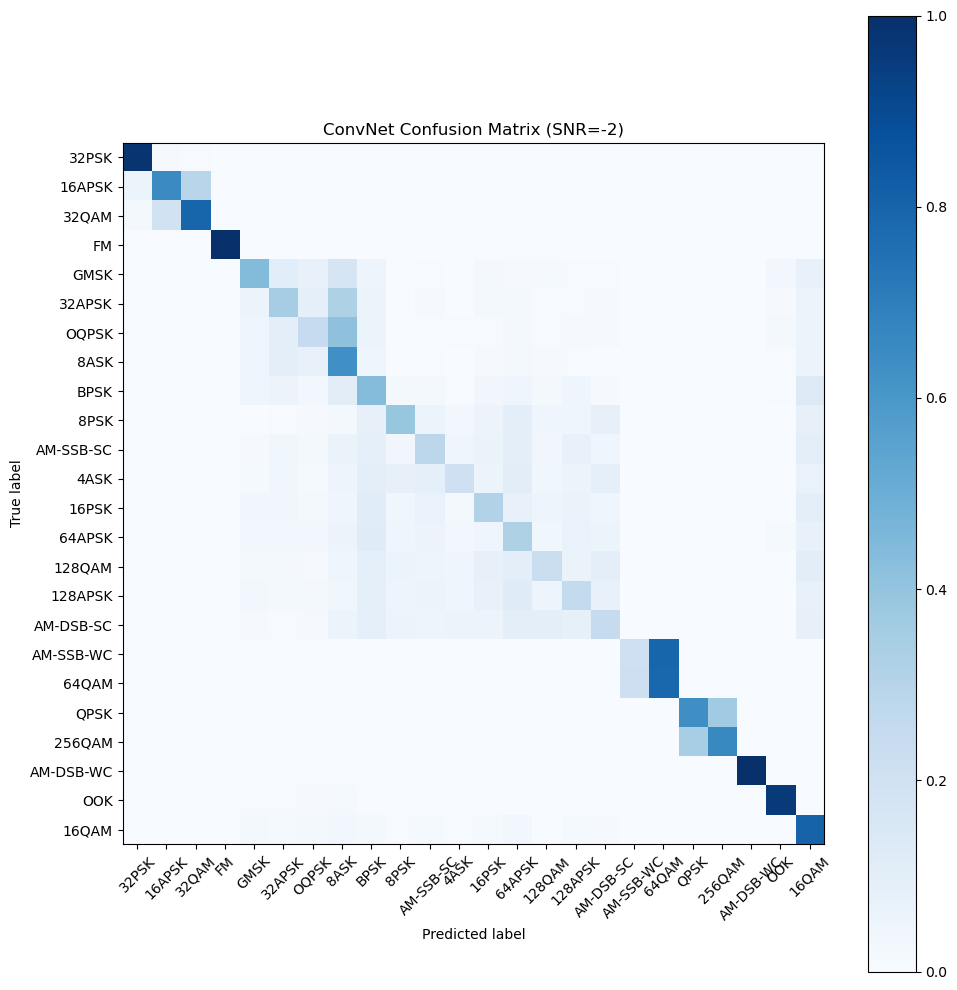

<Figure size 640x480 with 0 Axes>

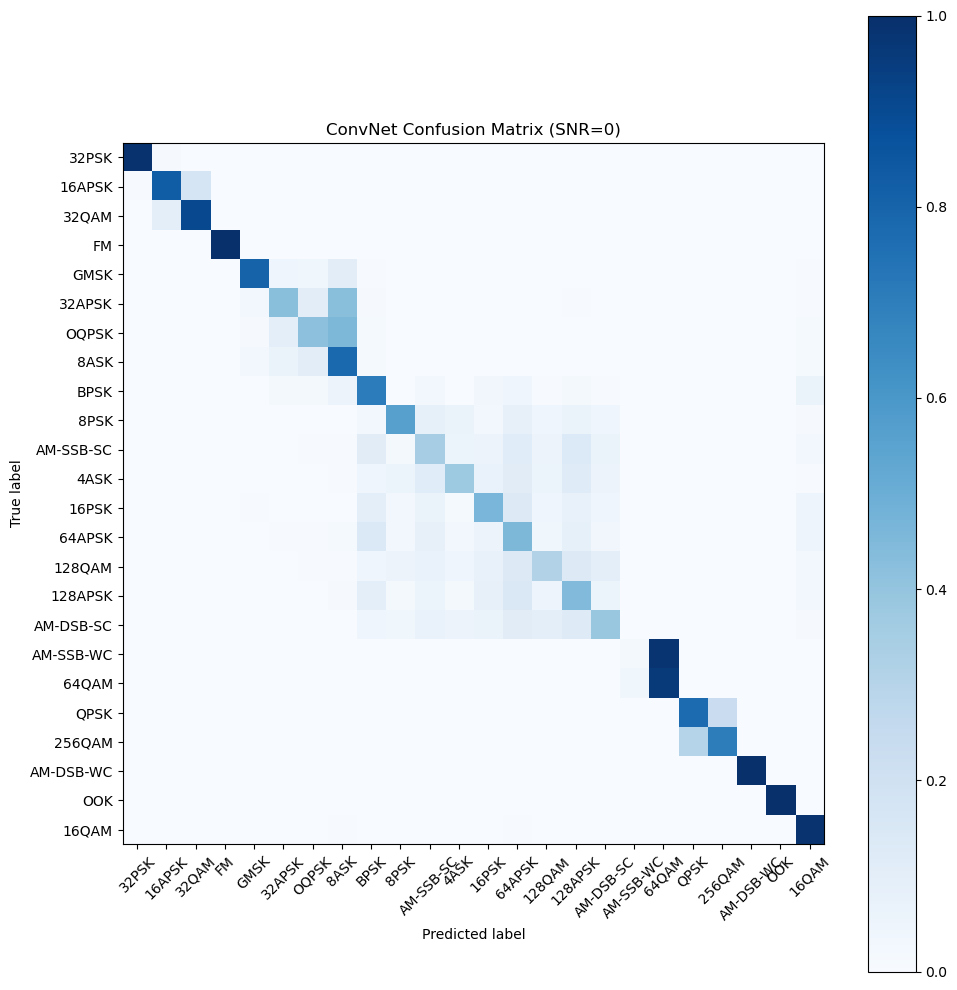

<Figure size 640x480 with 0 Axes>

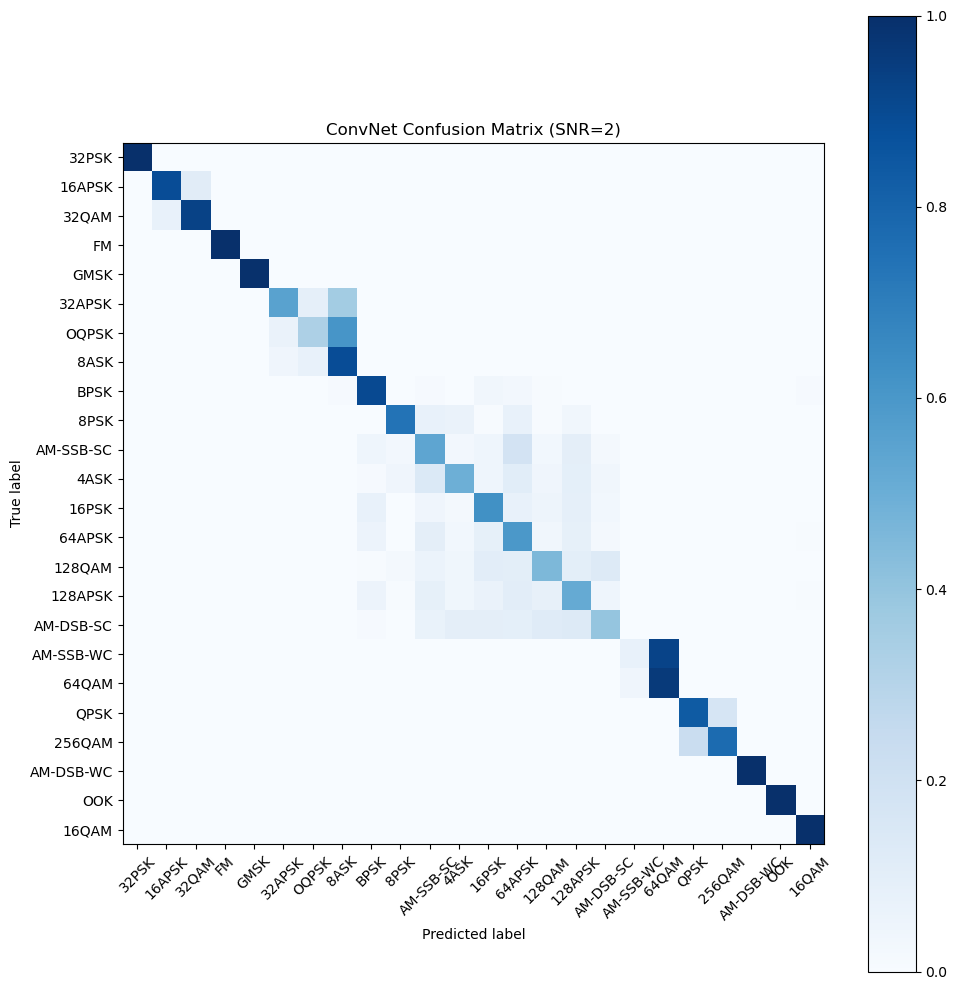

<Figure size 640x480 with 0 Axes>

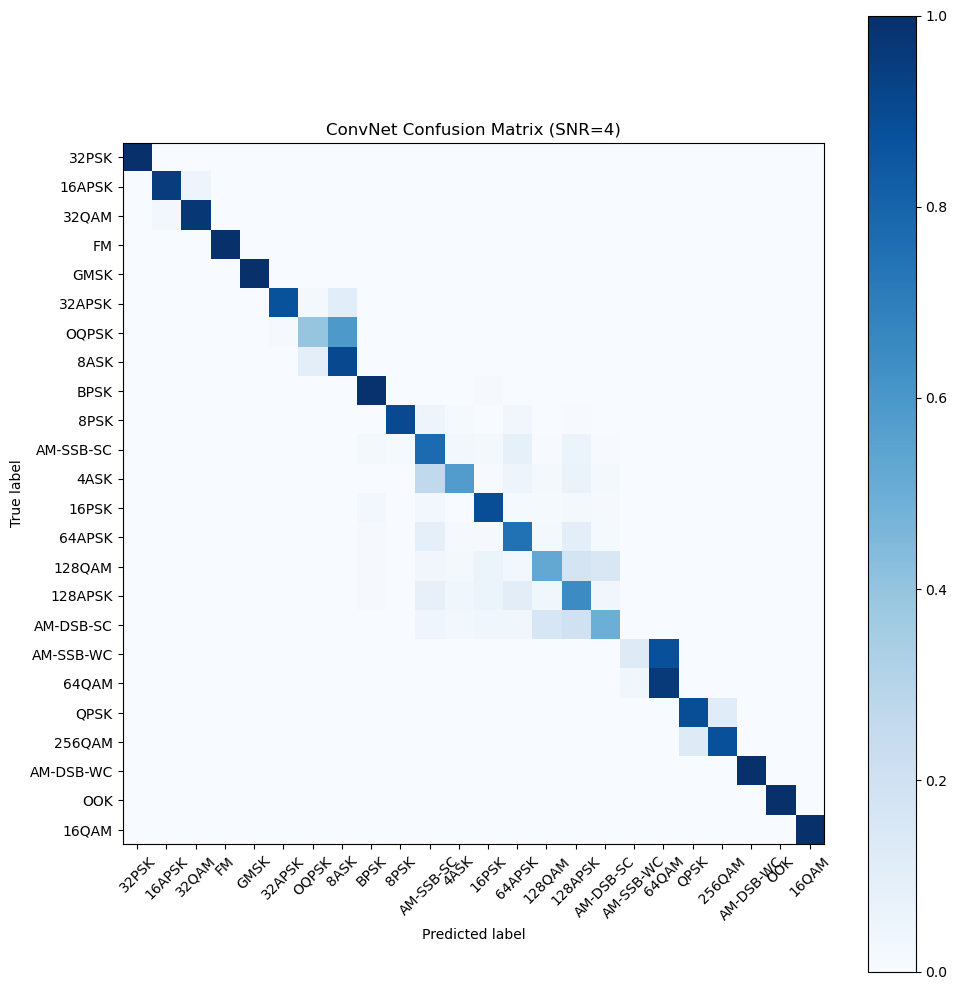

<Figure size 640x480 with 0 Axes>

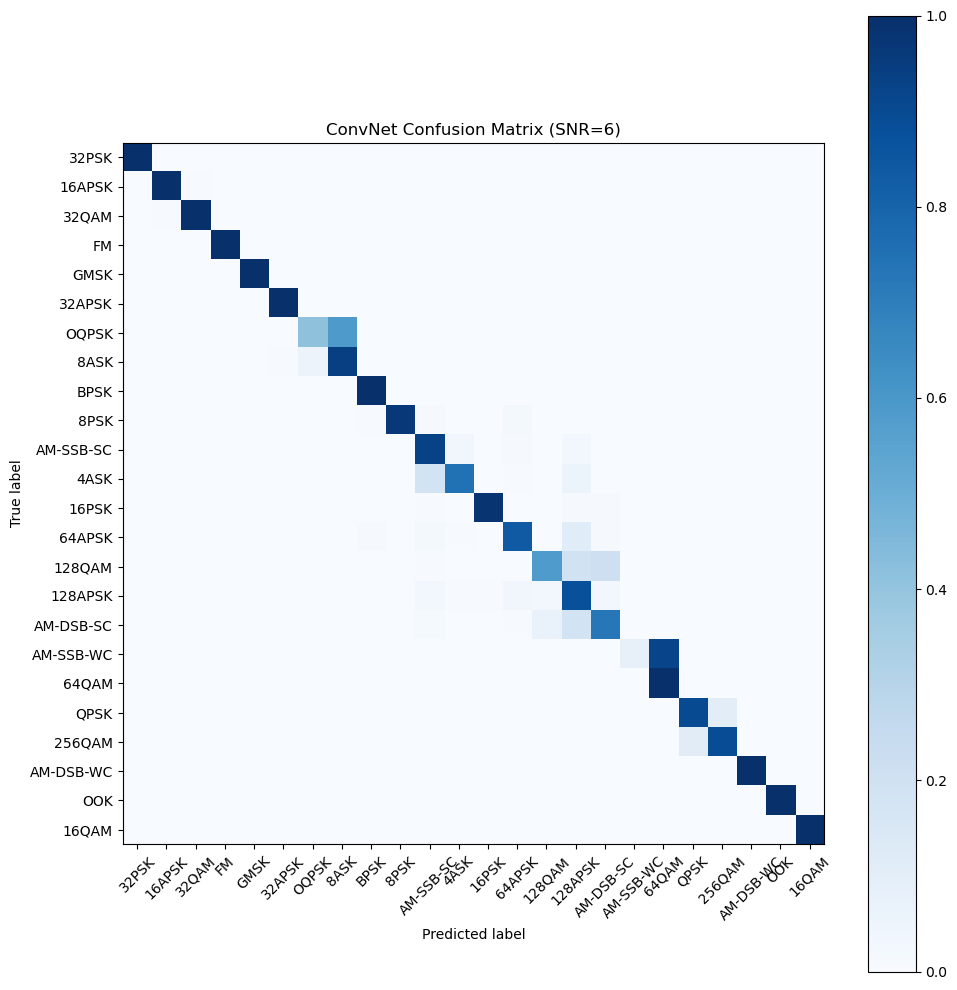

<Figure size 640x480 with 0 Axes>

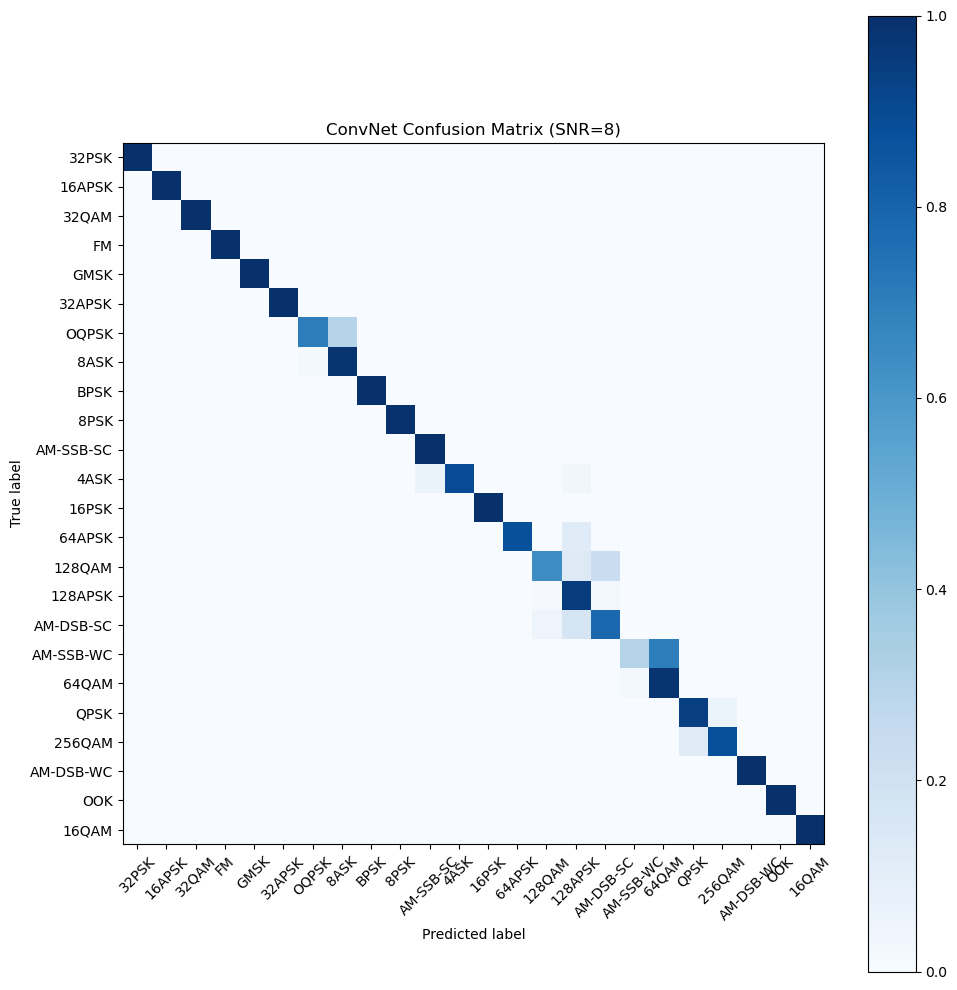

<Figure size 640x480 with 0 Axes>

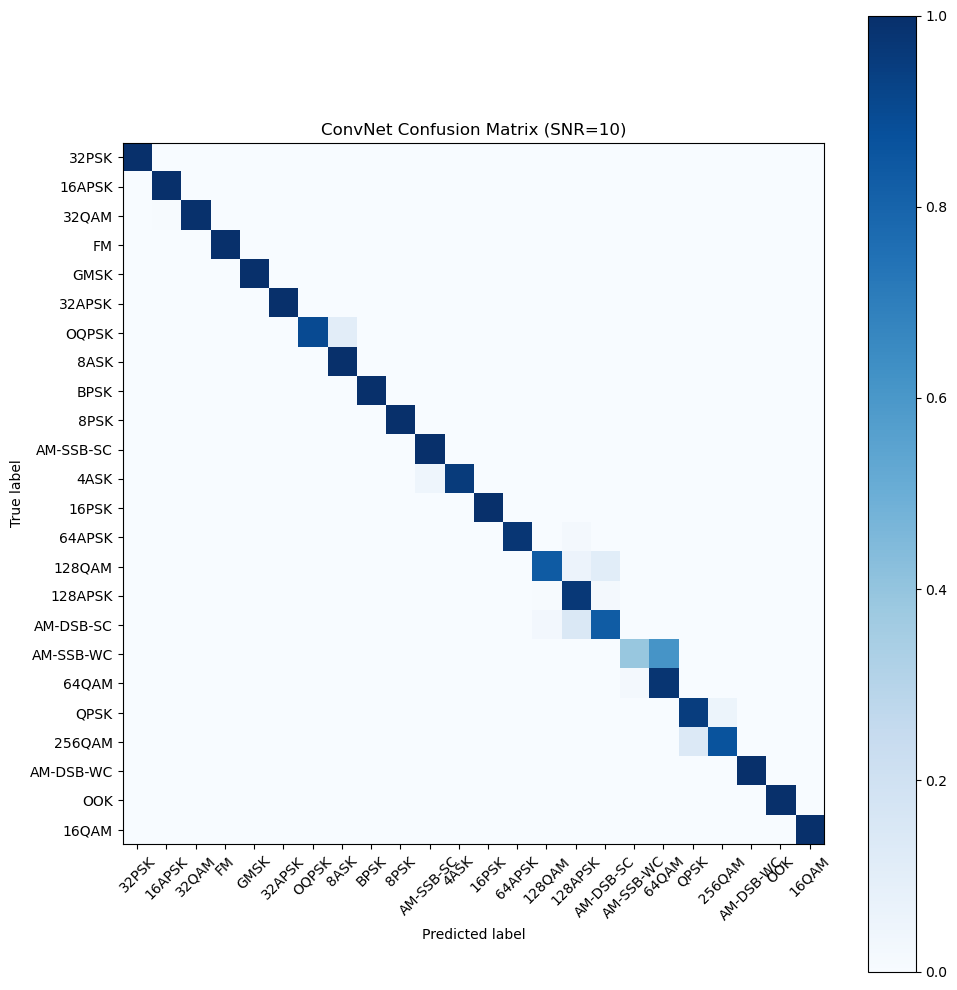

<Figure size 640x480 with 0 Axes>

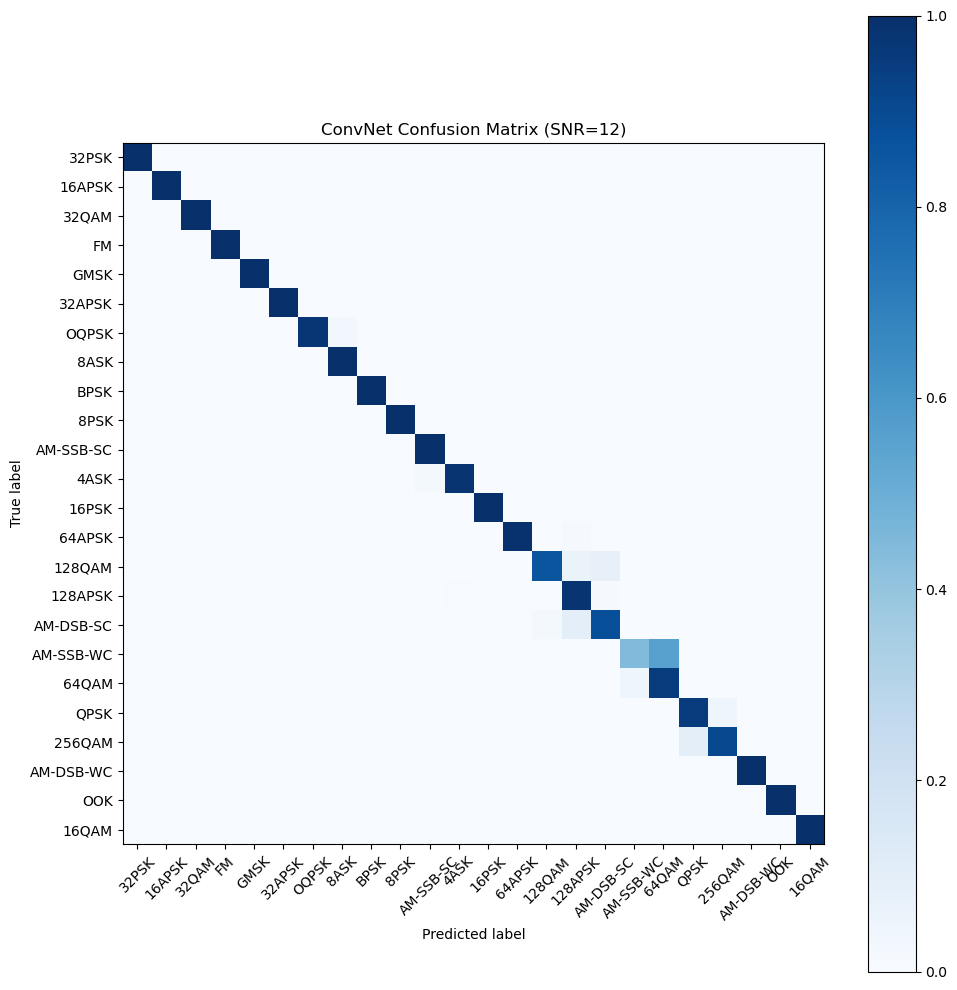

<Figure size 640x480 with 0 Axes>

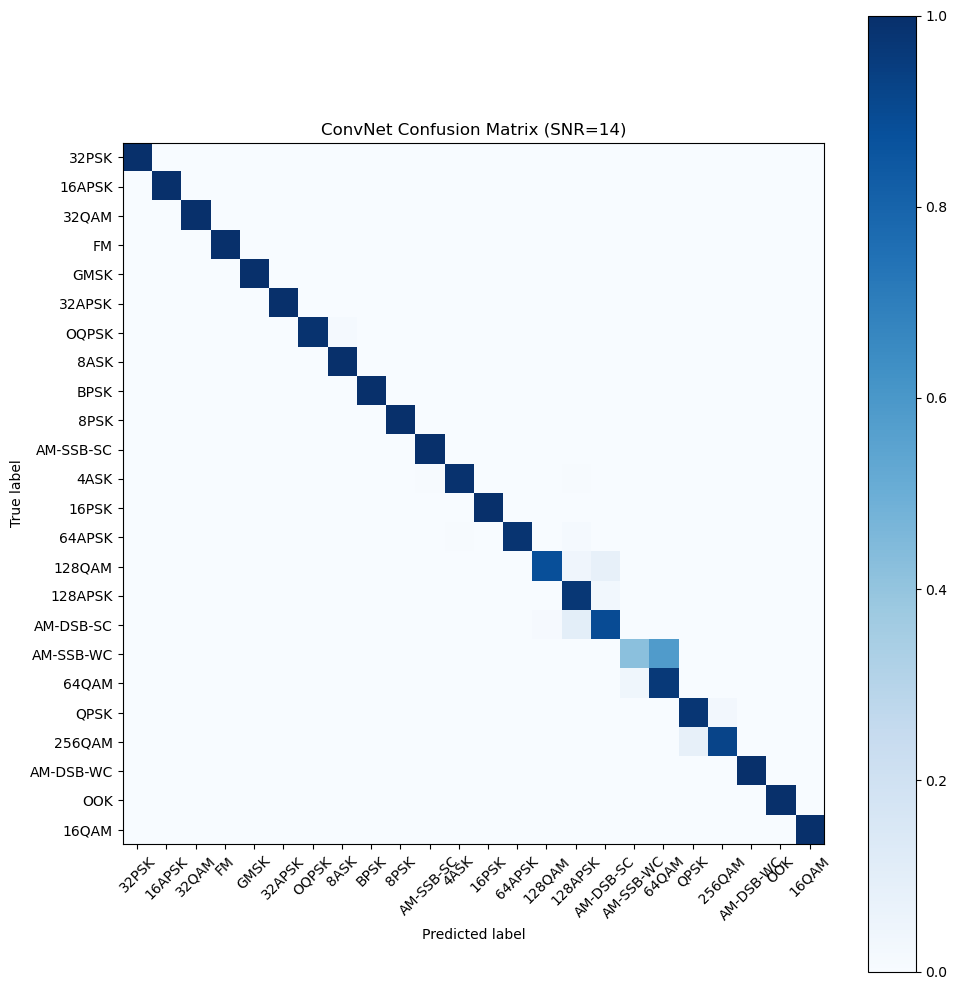

<Figure size 640x480 with 0 Axes>

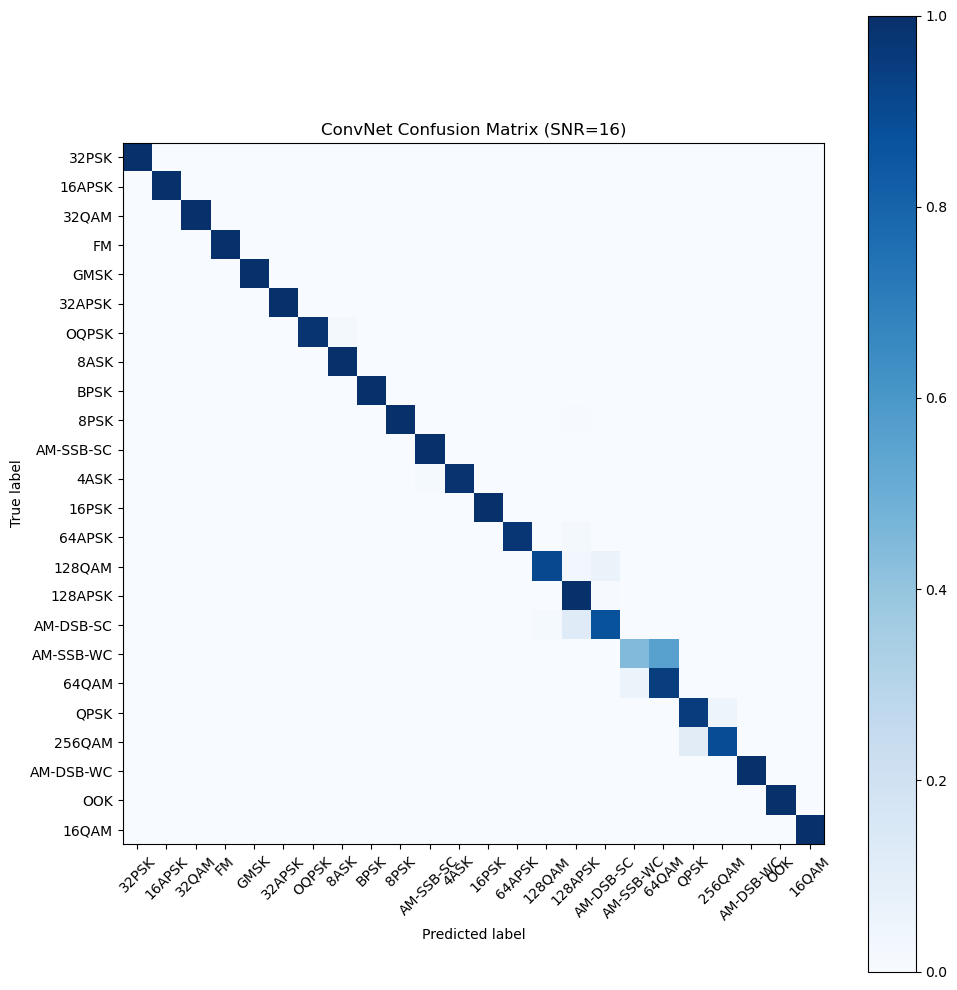

<Figure size 640x480 with 0 Axes>

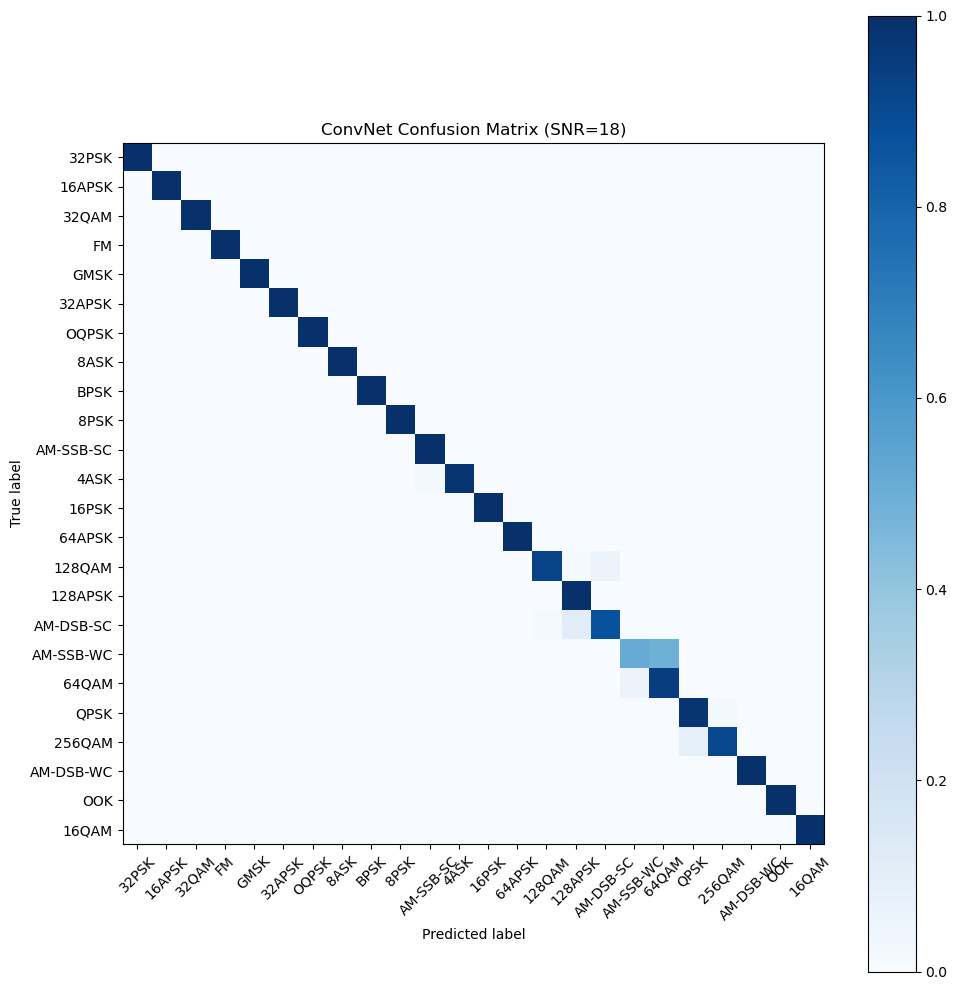

<Figure size 640x480 with 0 Axes>

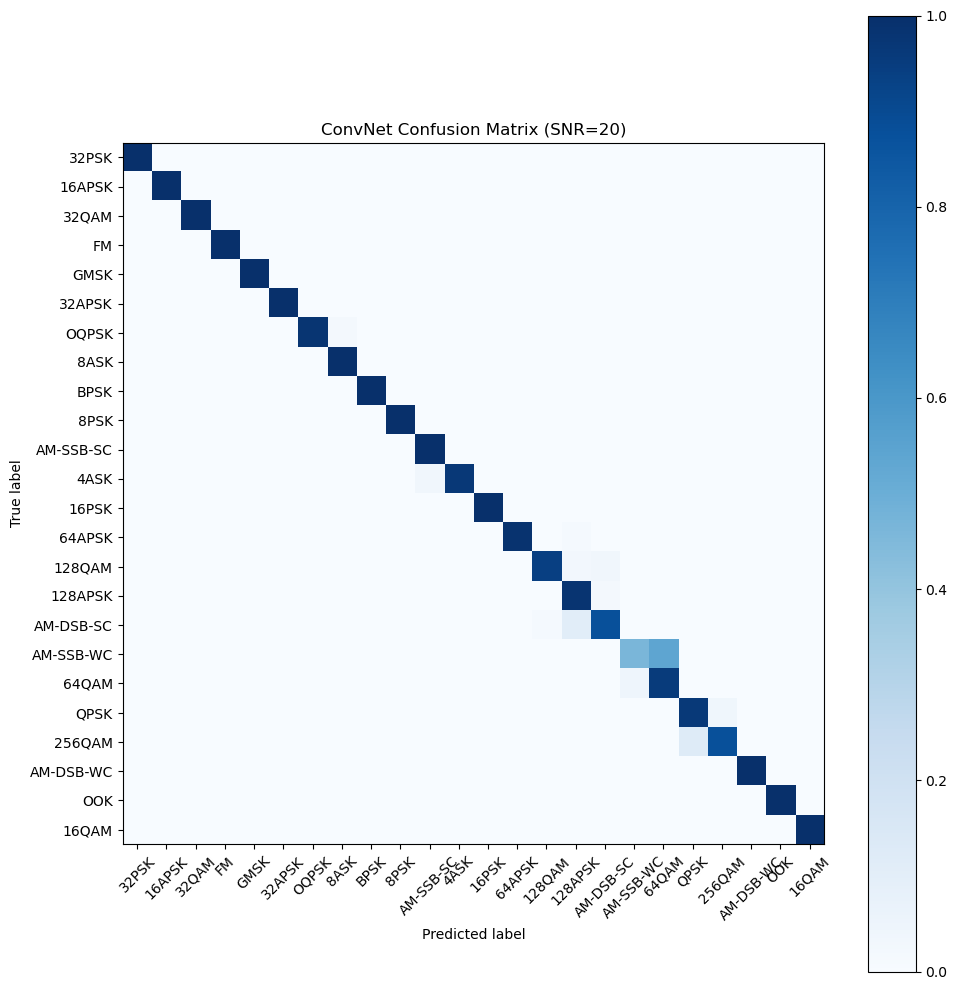

<Figure size 640x480 with 0 Axes>

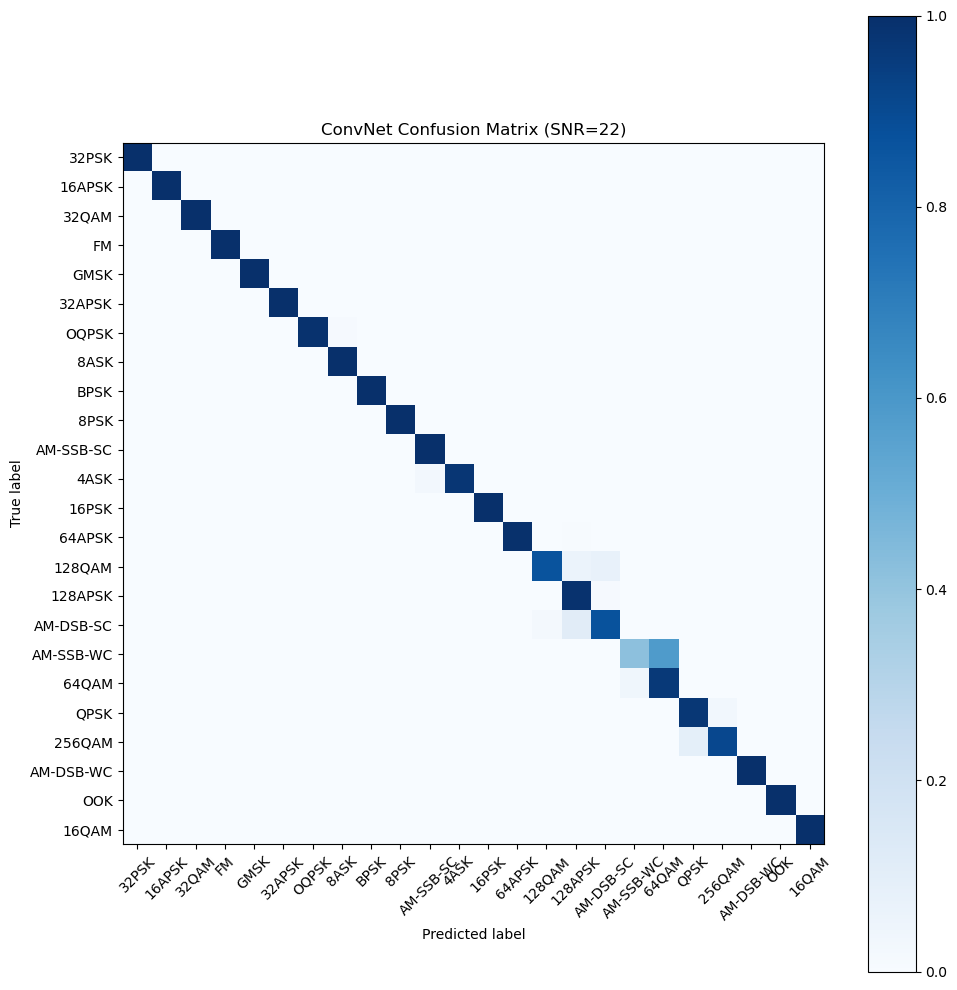

<Figure size 640x480 with 0 Axes>

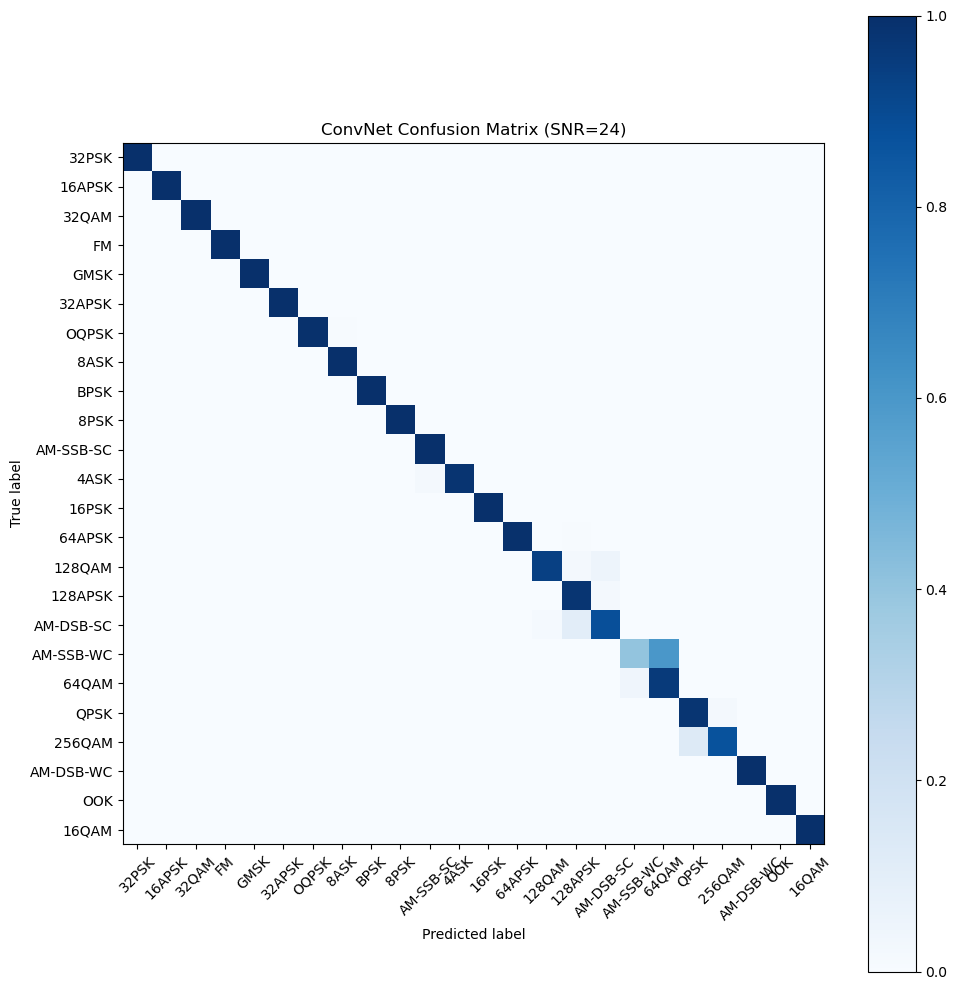

<Figure size 640x480 with 0 Axes>

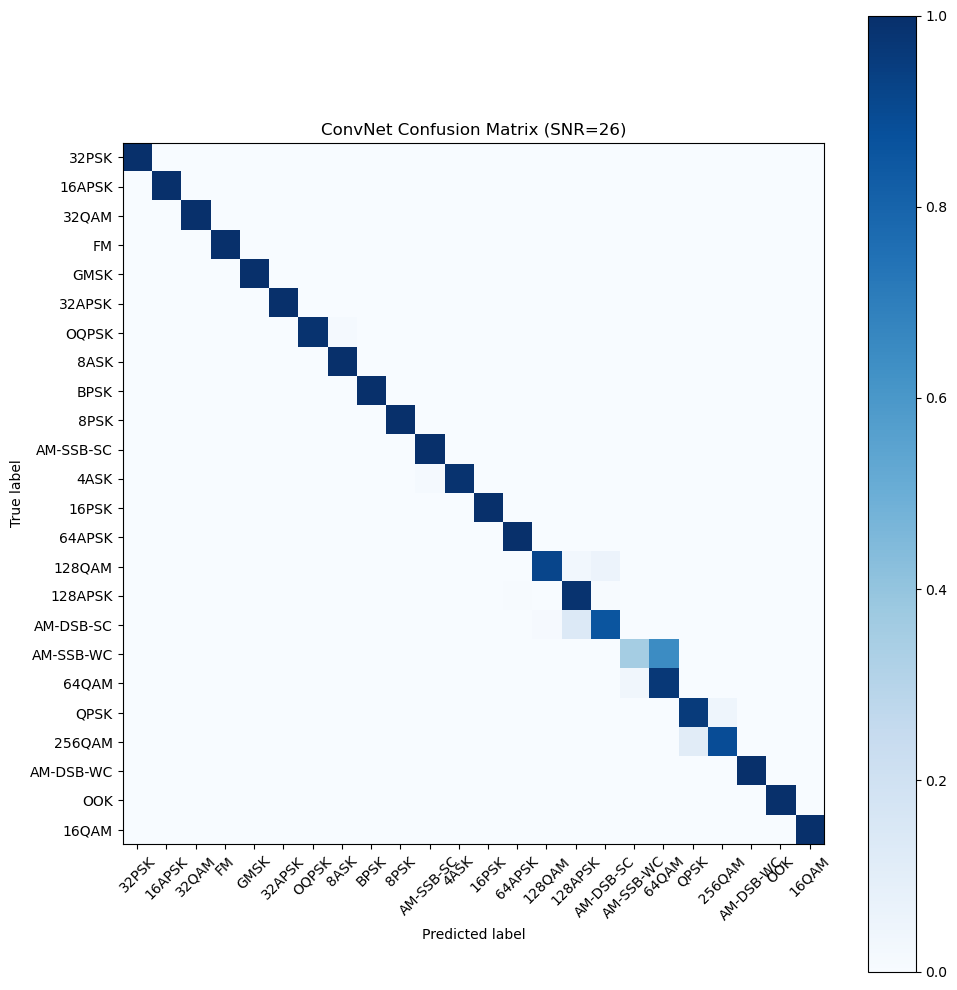

<Figure size 640x480 with 0 Axes>

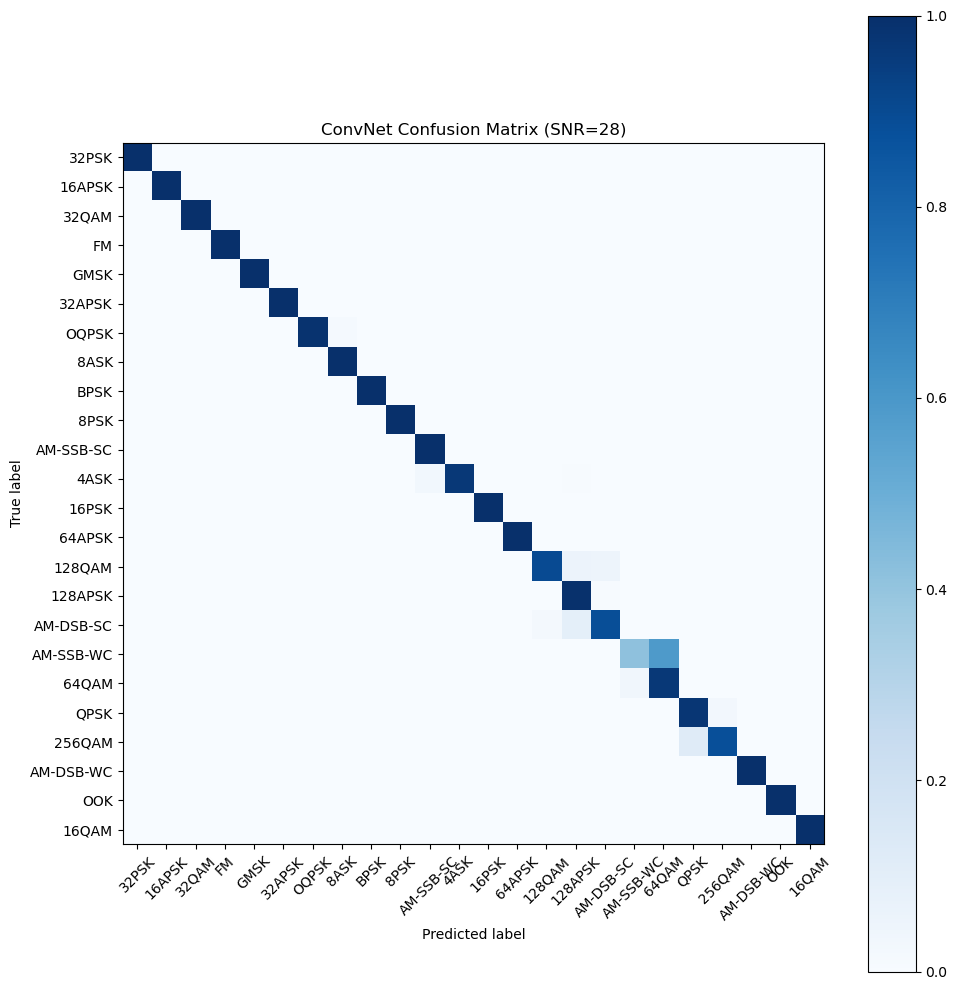

<Figure size 640x480 with 0 Axes>

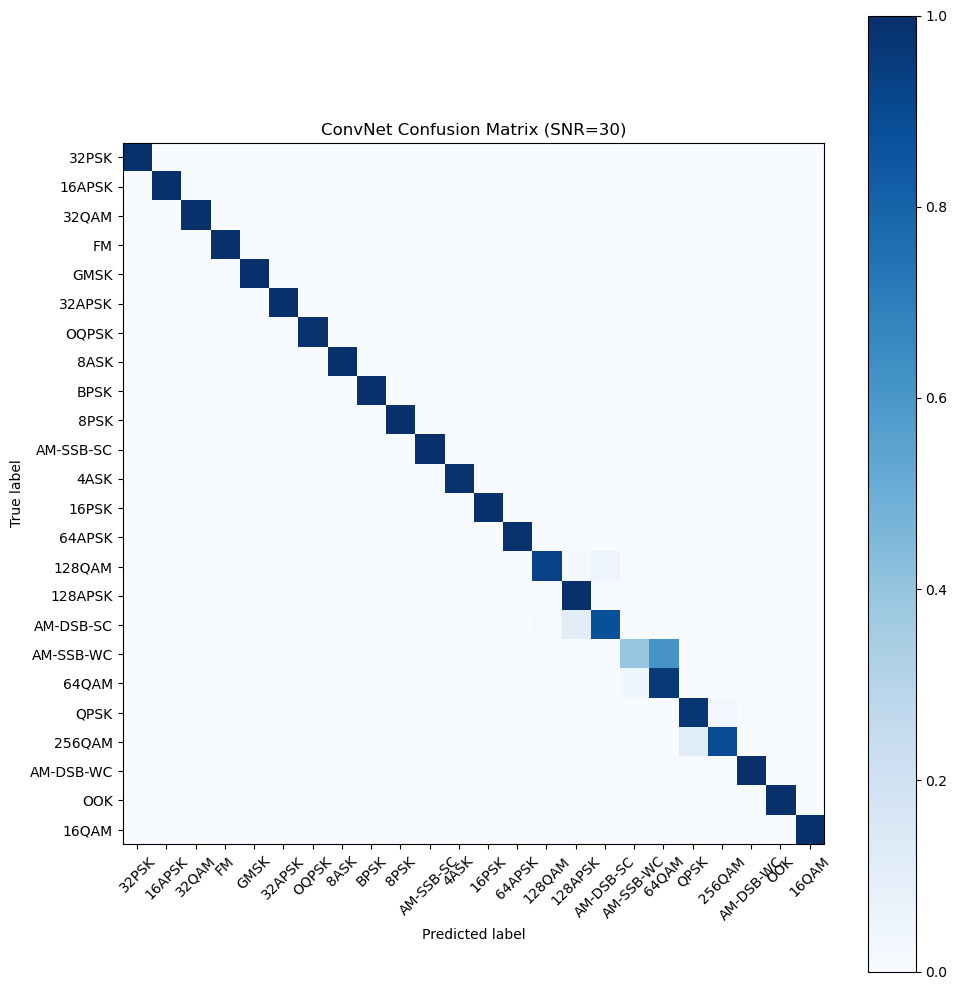

In [33]:

acc={}
Z_test = Z[test_idx]
Z_test = Z_test.reshape((len(Z_test)))
SNRs = np.unique(Z_test)
for snr in SNRs:
    X_test_snr = X_test[Z_test==snr]
    Y_test_snr = Y_test[Z_test==snr]
    
    pre_Y_test = model.predict(X_test_snr)
    conf = np.zeros([len(classes),len(classes)])
    confnorm = np.zeros([len(classes),len(classes)])
    for i in range(0,X_test_snr.shape[0]):    
        j = list(Y_test_snr[i,:]).index(1)   
        k = int(np.argmax(pre_Y_test[i,:])) 
        conf[j,k] = conf[j,k] + 1
    for i in range(0,len(classes)):
        confnorm[i,:] = conf[i,:] / np.sum(conf[i,:])
   
    plt.figure()
    plot_confusion_matrix(confnorm, labels=classes, title="ConvNet Confusion Matrix (SNR=%d)"%(snr))
    
    cor = np.sum(np.diag(conf))
    ncor = np.sum(conf) - cor
    print ("Overall Accuracy %s: "%snr, cor / (cor+ncor))
    acc[snr] = 1.0*cor/(cor+ncor)

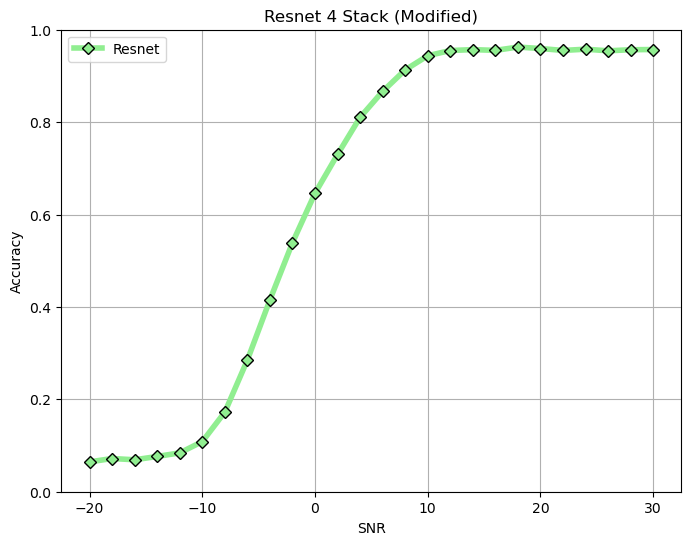

In [34]:
plt.figure(figsize=(8,6))
plt.plot(acc.keys(),acc.values(),linewidth=4,color='lightgreen', marker='D', markeredgecolor='black')
plt.ylim(0, 1) 
plt.ylabel('Accuracy')
plt.xlabel('SNR')
plt.title('Resnet 4 Stack (Modified)')
plt.grid()
plt.legend(['Resnet'],loc='upper left')
plt.show()